# **IMPORTACIONES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

from pathlib import Path
from ipywidgets import interact
import os

from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure
import torch
from torchvision.transforms.functional import to_tensor
from PIL import Image

ms_ssim = MultiScaleStructuralSimilarityIndexMeasure()

from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor, Resize, Compose, Normalize, Lambda
from PIL import Image
from torchmetrics.image.fid import FrechetInceptionDistance

import lpips
from torchvision.transforms import ToTensor, Resize, Compose
import statistics

from matplotlib.patches import Rectangle
import cv2
from torchvision.transforms import functional as F

# **ALGUNAS VISUALIZACIONES**

### **Ejemplo por paciente**

In [22]:
# Ruta de paciente en especifico
ruta_real_B_per_paciente = "results/p2p_esp_none_ADC_FLAIR/test_latest/images_grayscale/real_B/022" 
ruta_fake_B_per_paciente = "results/p2p_esp_none_ADC_FLAIR/test_latest/images_grayscale/fake_B/022"

In [23]:
# Obtener la lista de archivos en las rutas
archivos_real_B = sorted(Path(ruta_real_B_per_paciente).glob("*.png"))
archivos_fake_B = sorted(Path(ruta_fake_B_per_paciente).glob("*.png"))

# Cargar las imágenes en listas
imagenes_real_B = [plt.imread(str(f)) for f in archivos_real_B]
imagenes_fake_B = [plt.imread(str(f)) for f in archivos_fake_B]

#verificar dimensiones
for i, img in enumerate(imagenes_real_B):
    assert img.shape == (256, 256), f"Image {i} in real_B has shape {img.shape}"
for i, img in enumerate(imagenes_fake_B):
    assert img.shape == (256, 256), f"Image {i} in fake_B has shape {img.shape}"
    
#Agrupar volumen
volume_real_B = np.stack(imagenes_real_B, axis=-1)
volume_fake_B = np.stack(imagenes_fake_B, axis=-1)

In [24]:
def browse_volume(volume, ssim_value=""):
    def view_image(i):
        plt.imshow(volume[:, :, i], cmap="gray")
        plt.title(ssim_value)
        plt.show()

    interact(view_image, i=(0, volume.shape[2] - 1))

In [25]:
ssim_value = ssim(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min())

print(f"Índice de similitud estructural (SSIM) entre real_B y fake_B: {ssim_value:.3f}")

browse_volume(volume_fake_B, ssim_value=f"SSIM: {ssim_value:.3f}")

Índice de similitud estructural (SSIM) entre real_B y fake_B: 0.926


interactive(children=(IntSlider(value=11, description='i', max=23), Output()), _dom_classes=('widget-interact'…

## **RUTAS PARA MÉTRICAS**

In [26]:
# Rutas de las carpetas de imagenes fake y reales
ruta_real_B = "results/p2p_esp_none_ADC_FLAIR/test_latest/images_grayscale/real_B" 
ruta_fake_B = "results/p2p_esp_none_ADC_FLAIR/test_latest/images_grayscale/fake_B"
ruta_masks = 'datasets/masks_flair_test_organizado'

# **MÉTRICAS ESTANDAR**

## **SSIM**

In [27]:
# Obtener la lista de carpetas de pacientes
carpetas_pacientes_real_B = sorted(Path(ruta_real_B).glob("*"))
carpetas_pacientes_fake_B = sorted(Path(ruta_fake_B).glob("*"))

ssim_values = []

for carpeta_paciente_real_B, carpeta_paciente_fake_B in zip(carpetas_pacientes_real_B, carpetas_pacientes_fake_B):
    id_paciente = carpeta_paciente_real_B.stem
    archivos_real_B = sorted(carpeta_paciente_real_B.glob("*.png"))
    archivos_fake_B = sorted(carpeta_paciente_fake_B.glob("*.png"))

    imagenes_real_B = [plt.imread(str(f)) for f in archivos_real_B]
    imagenes_fake_B = [plt.imread(str(f)) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = np.stack(imagenes_real_B, axis=-1)
    volume_fake_B = np.stack(imagenes_fake_B, axis=-1)

    ssim_value = ssim(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min())
    ssim_values.append(ssim_value)
    #print(f"paciente: {id_paciente}, SSIM: {ssim_value:.3f}")


promedio_ssim = np.mean(ssim_values)
desviacion_estandar_ssim = np.std(ssim_values)
print(f"SSIM Promedio: {promedio_ssim:.3f}, Desviación Estándar SSIM: {desviacion_estandar_ssim:.3f}")

SSIM Promedio: 0.911, Desviación Estándar SSIM: 0.026


## **PSNR**

In [28]:
carpetas_pacientes_real_B = sorted(Path(ruta_real_B).glob("*"))
carpetas_pacientes_fake_B = sorted(Path(ruta_fake_B).glob("*"))

psnr_values = []

for carpeta_paciente_real_B, carpeta_paciente_fake_B in zip(carpetas_pacientes_real_B, carpetas_pacientes_fake_B):
    id_paciente = carpeta_paciente_real_B.stem
    archivos_real_B = sorted(carpeta_paciente_real_B.glob("*.png"))
    archivos_fake_B = sorted(carpeta_paciente_fake_B.glob("*.png"))

    imagenes_real_B = [plt.imread(str(f)) for f in archivos_real_B]
    imagenes_fake_B = [plt.imread(str(f)) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = np.stack(imagenes_real_B, axis=-1)
    volume_fake_B = np.stack(imagenes_fake_B, axis=-1)

    psnr_value = psnr(volume_real_B, volume_fake_B)
    psnr_values.append(psnr_value)
    #print(f"paciente: {id_paciente}, PSNR: {psnr_value:.3f}")


promedio_psnr = np.mean(psnr_values)
desviacion_estandar_psnr = np.std(psnr_values)
print(f"PSNR Promedio: {promedio_psnr:.3f}, Desviación Estándar PSNR: {desviacion_estandar_psnr:.3f}")

PSNR Promedio: 24.464, Desviación Estándar PSNR: 1.282


## **MS-SSIM**

In [29]:
# Obtener la lista de carpetas de pacientes
carpetas_pacientes_real_B = sorted(Path(ruta_real_B).glob("*"))
carpetas_pacientes_fake_B = sorted(Path(ruta_fake_B).glob("*"))

ms_ssim = MultiScaleStructuralSimilarityIndexMeasure()

ms_ssim_values = []

for carpeta_paciente_real_B, carpeta_paciente_fake_B in zip(carpetas_pacientes_real_B, carpetas_pacientes_fake_B):
    id_paciente = carpeta_paciente_real_B.stem
    archivos_real_B = sorted(carpeta_paciente_real_B.glob("*.png"))
    archivos_fake_B = sorted(carpeta_paciente_fake_B.glob("*.png"))

    imagenes_real_B = [to_tensor(Image.open(str(f))) for f in archivos_real_B]
    imagenes_fake_B = [to_tensor(Image.open(str(f))) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (1, 256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (1, 256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = torch.stack(imagenes_real_B, dim=0)
    volume_fake_B = torch.stack(imagenes_fake_B, dim=0)

    ms_ssim_value = ms_ssim(volume_fake_B, volume_real_B)
    ms_ssim_values.append(ms_ssim_value)  # Agregar valor de MS-SSIM a la lista
    #print(f"paciente: {id_paciente}, MS-SSIM: {ms_ssim_value:.3f}")


promedio_ms_ssim = np.mean(ms_ssim_values)
desviacion_estandar_ms_ssim = np.std(ms_ssim_values)
print(f"MS-SSIM Promedio: {promedio_ms_ssim:.3f}, Desviación Estándar MS-SSIM: {desviacion_estandar_ms_ssim:.3f}")

MS-SSIM Promedio: 0.912, Desviación Estándar MS-SSIM: 0.033


# **MÉTRICAS PRE-ENTRENADAS**

## **FID**

In [30]:
path_real_images = Path(ruta_real_B)
path_fake_images = Path(ruta_fake_B)

transform = Compose([
    Resize((299, 299)),  # Dimensiones esperadas por InceptionV3
    Lambda(lambda img: np.array(img)),  # Convertir imagen a array numpy
    Lambda(lambda x: torch.tensor(x).permute(2, 0, 1).to(torch.uint8)),  # Reordenar dimensiones y convertir a uint8
])

# Función para cargar y transformar imágenes
def load_images(path, transform):
    images = []
    for folder in path.iterdir():
        if folder.is_dir():  # Asegurarse de que es un directorio
            for img_path in folder.glob('*.png'):
                image = Image.open(img_path).convert('RGB')
                images.append(transform(image))
    return torch.stack(images)

# Cargar y transformar imágenes
real_images = load_images(path_real_images, transform)
fake_images = load_images(path_fake_images, transform)

# Crear DataLoaders
real_loader = DataLoader(TensorDataset(real_images), batch_size=32)
fake_loader = DataLoader(TensorDataset(fake_images), batch_size=32)

# Inicializar la métrica FID
fid_metric = FrechetInceptionDistance(feature=64)

# Actualizar la métrica con imágenes reales y generadas
for real_batch in real_loader:
    fid_metric.update(real_batch[0], real=True)
for fake_batch in fake_loader:
    fid_metric.update(fake_batch[0], real=False)

# Calcular y obtener la métrica FID
fid_score = fid_metric.compute()
print(f"FID Score: {fid_score}")


FID Score: 0.029797030612826347


## **LPIPS**

In [ ]:
# Cargar y preparar las imágenes
def load_and_preprocess_image(path):
    transform = Compose([Resize((256, 256)), ToTensor()])
    image = Image.open(path).convert('RGB')
    return transform(image).unsqueeze(0)  # Añadir dimensión de batch


# Inicializar LPIPS con modelo VGG
loss_fn = lpips.LPIPS(net='vgg')

real_images_dir = Path(ruta_real_B)
fake_images_dir = Path(ruta_fake_B)

# Obtener la lista de nombres de directorios de imágenes (IDs de pacientes)
real_patient_dirs = os.listdir(real_images_dir)
fake_patient_dirs = os.listdir(fake_images_dir)

distances = []

for patient_dir in real_patient_dirs:
    real_patient_images_dir = os.path.join(real_images_dir, patient_dir)
    fake_patient_images_dir = os.path.join(fake_images_dir, patient_dir)
    
    # Obtener la lista de nombres de archivo de las imágenes
    real_images_list = [f for f in os.listdir(real_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    fake_images_list = [f for f in os.listdir(fake_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Iterar sobre las imágenes y calcular LPIPS
    for real_image_name, fake_image_name in zip(real_images_list, fake_images_list):
        # Cargar imágenes
        real_image = load_and_preprocess_image(os.path.join(real_patient_images_dir, real_image_name))
        fake_image = load_and_preprocess_image(os.path.join(fake_patient_images_dir, fake_image_name))

        # Calcular LPIPS
        dist = loss_fn(real_image, fake_image)
        distances.append(dist.item())

# Calcular la distancia LPIPS promedio si hay elementos en la lista
if distances:
    average_distance = sum(distances) / len(distances)
    std_deviation = statistics.stdev(distances)
    print('Average LPIPS Distance:', "{:.3f}".format(average_distance))
    print('Standard Deviation of LPIPS Distance:', "{:.3f}".format(std_deviation))
else:
    print('No se encontraron directorios de imagenes.')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


# **MÉTRICAS ENTRE LAS LESIONES**

## **SSIM, PSNR y MS-SSIM**

### **Los que deberían verse en FLAIR**

Real_B ID: 002, Fake_B ID: 002, Masks ID: 002
Paciente: 002, Slice 3 - SSIM: 0.638, PSNR: 18.364, MS-SSIM: 0.649


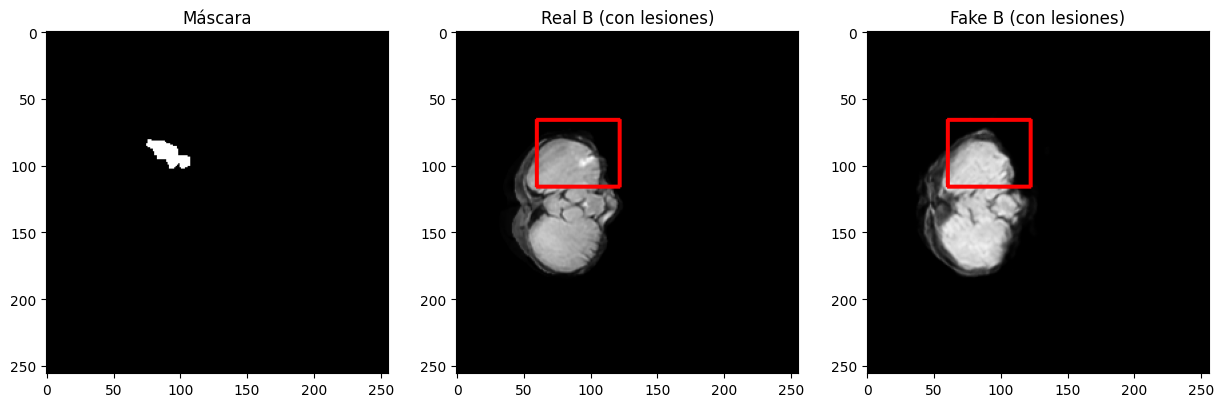

Paciente: 002, Slice 4 - SSIM: 0.591, PSNR: 15.850, MS-SSIM: 0.586


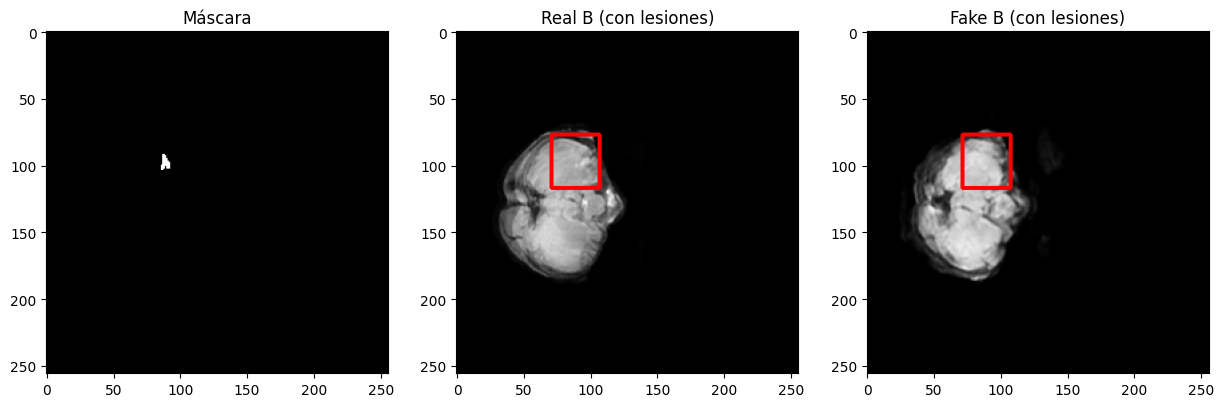

Paciente: 002, Slice 5 - SSIM: 0.480, PSNR: 16.369, MS-SSIM: 0.450


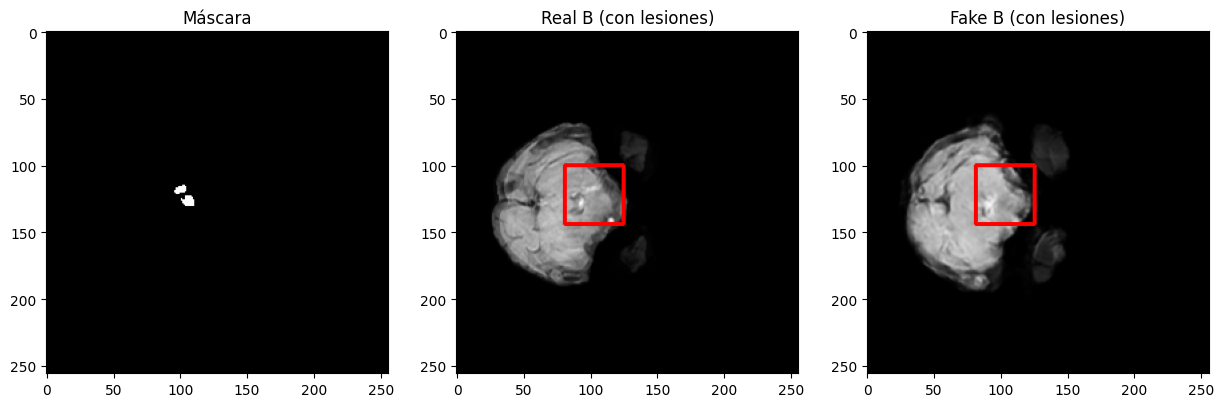

Promedio SSIM del paciente 002: 0.570
Promedio PSNR del paciente 002: 16.861
Promedio MS-SSIM del paciente 002: 0.562
Real_B ID: 006, Fake_B ID: 006, Masks ID: 006
Paciente: 006, Slice 14 - SSIM: 0.614, PSNR: 17.611, MS-SSIM: 0.606


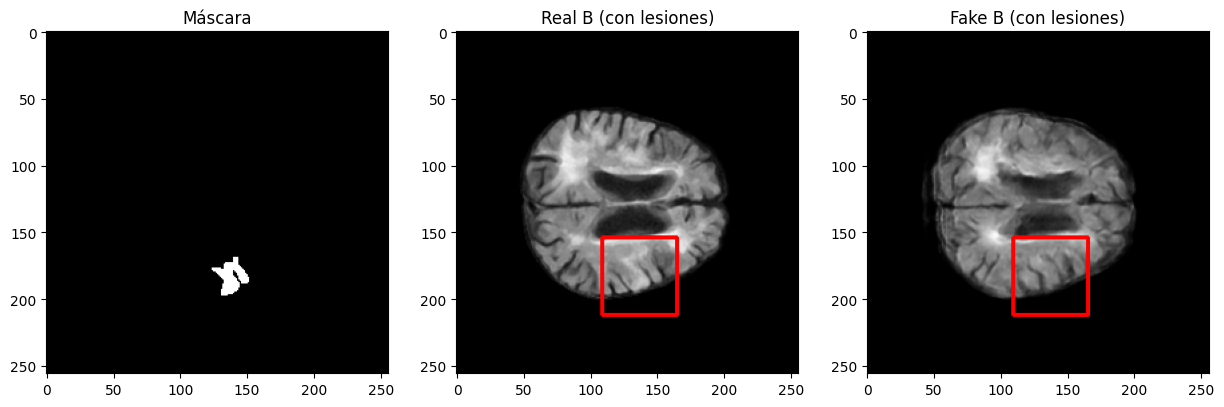

Paciente: 006, Slice 15 - SSIM: 0.572, PSNR: 18.056, MS-SSIM: 0.604


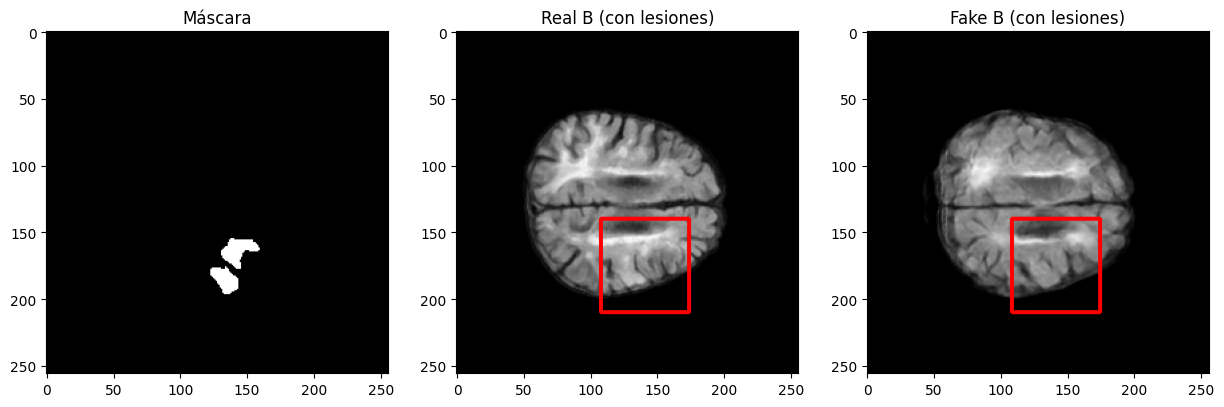

Paciente: 006, Slice 16 - SSIM: 0.543, PSNR: 18.406, MS-SSIM: 0.580


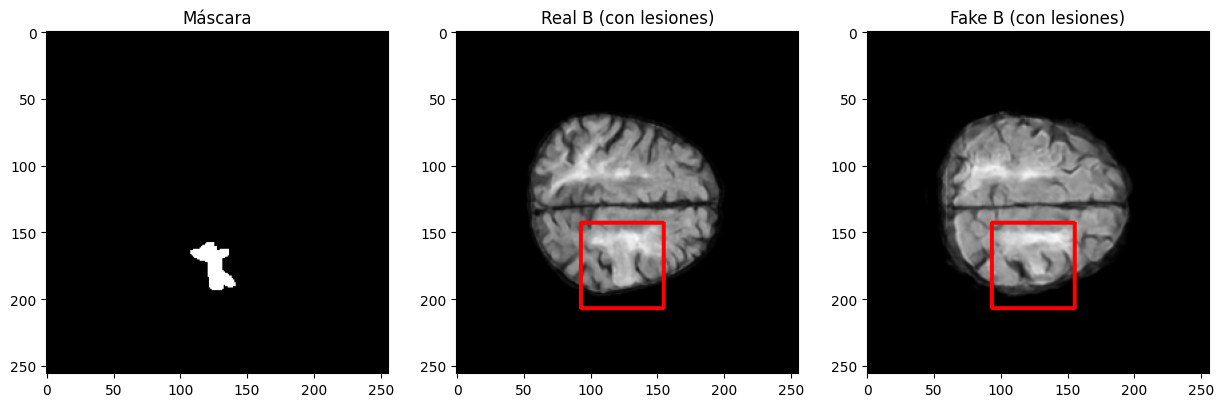

Paciente: 006, Slice 17 - SSIM: 0.484, PSNR: 16.948, MS-SSIM: 0.471


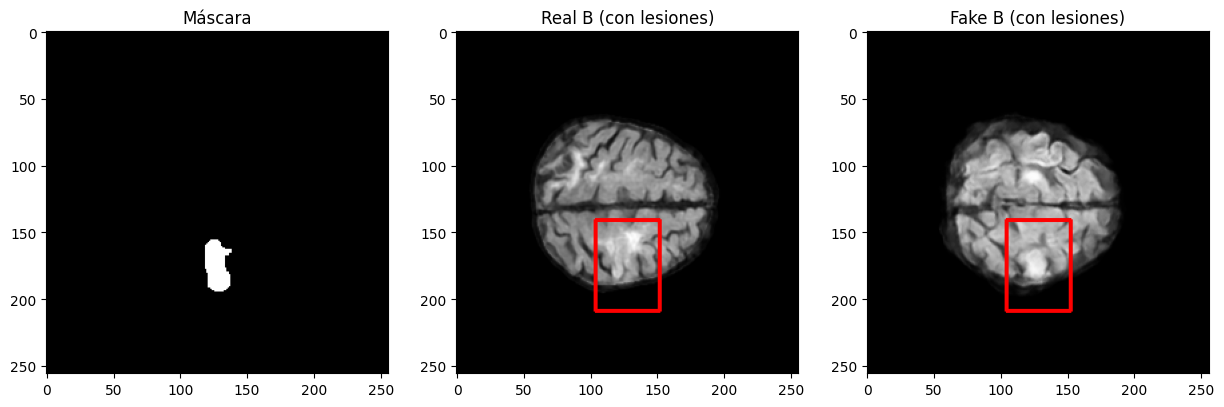

Paciente: 006, Slice 18 - SSIM: 0.404, PSNR: 14.821, MS-SSIM: 0.327


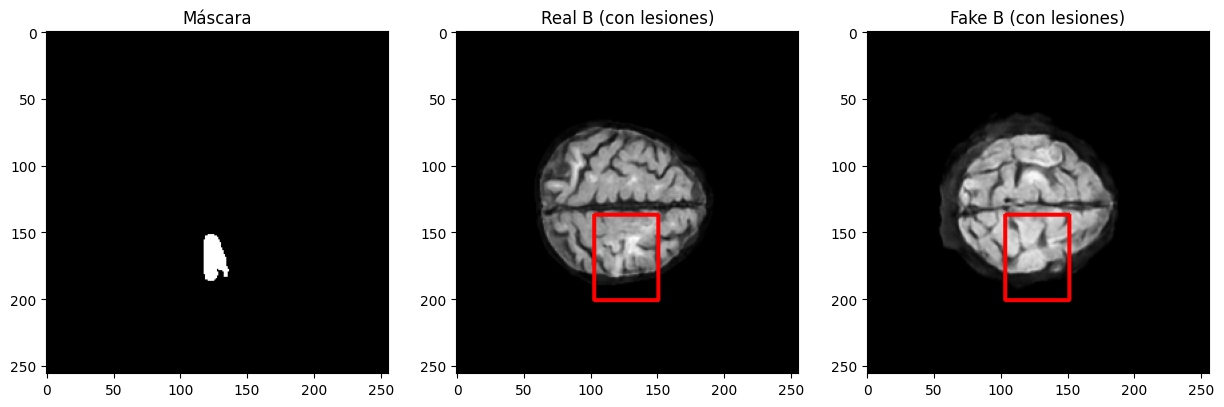

Paciente: 006, Slice 19 - SSIM: 0.426, PSNR: 13.684, MS-SSIM: 0.370


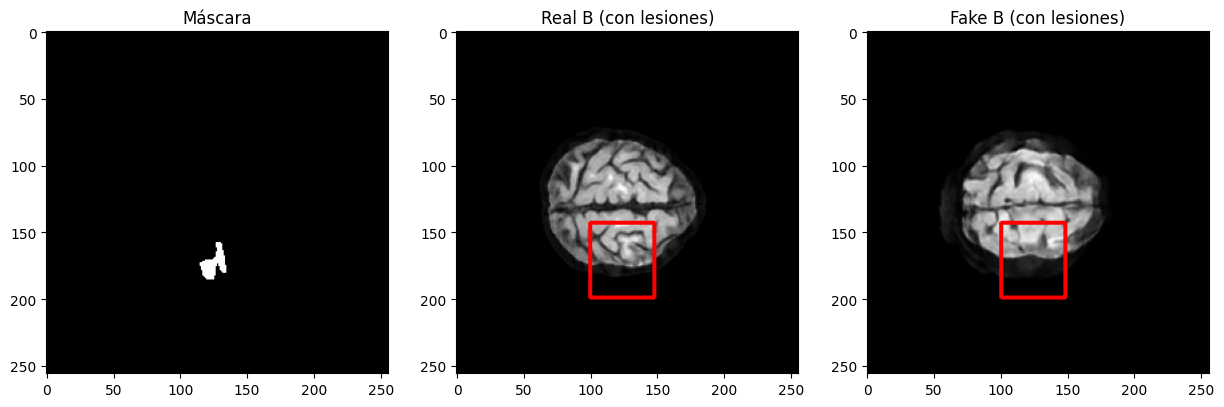

Promedio SSIM del paciente 006: 0.507
Promedio PSNR del paciente 006: 16.588
Promedio MS-SSIM del paciente 006: 0.493
Real_B ID: 007, Fake_B ID: 007, Masks ID: 007
Paciente: 007, Slice 19 - SSIM: 0.556, PSNR: 15.898, MS-SSIM: 0.458


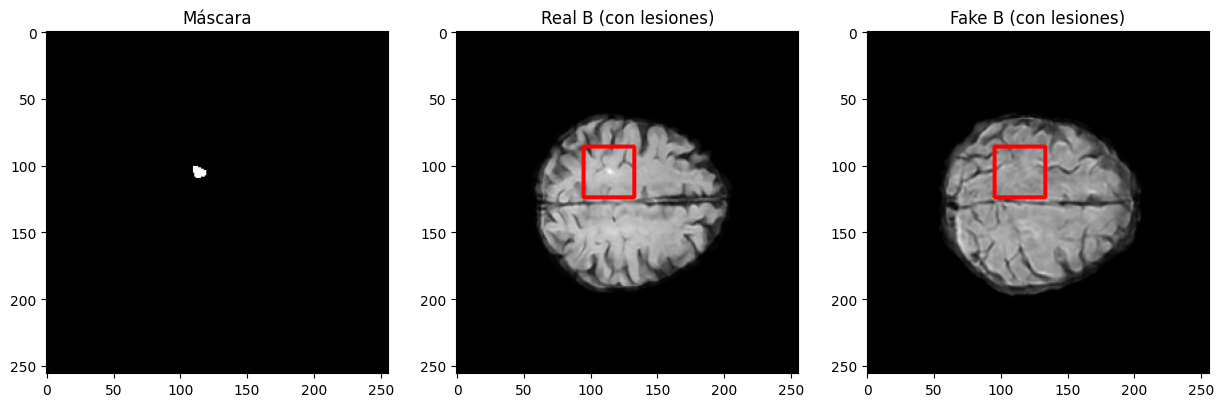

Paciente: 007, Slice 20 - SSIM: 0.374, PSNR: 9.826, MS-SSIM: 0.269


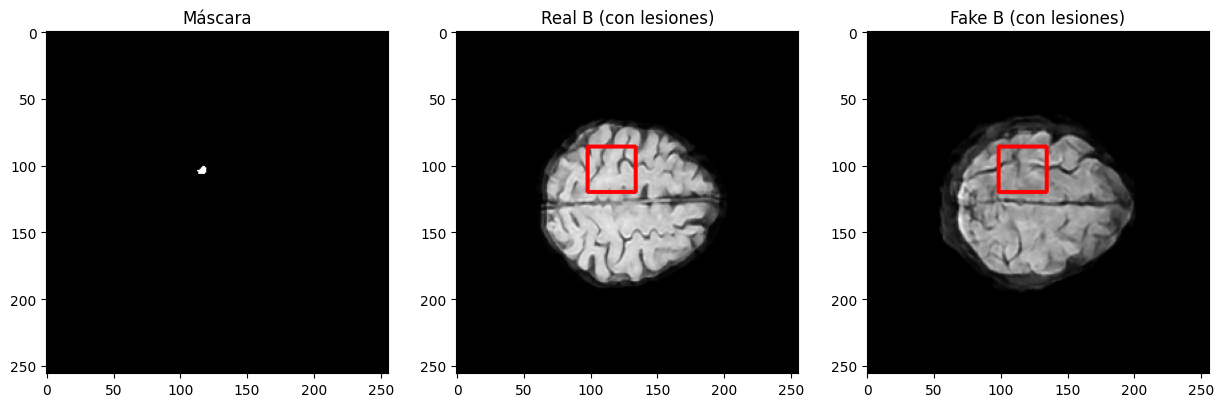

Promedio SSIM del paciente 007: 0.465
Promedio PSNR del paciente 007: 12.862
Promedio MS-SSIM del paciente 007: 0.364
Real_B ID: 009, Fake_B ID: 009, Masks ID: 009
Paciente: 009, Slice 10 - SSIM: 0.431, PSNR: 9.529, MS-SSIM: 0.457


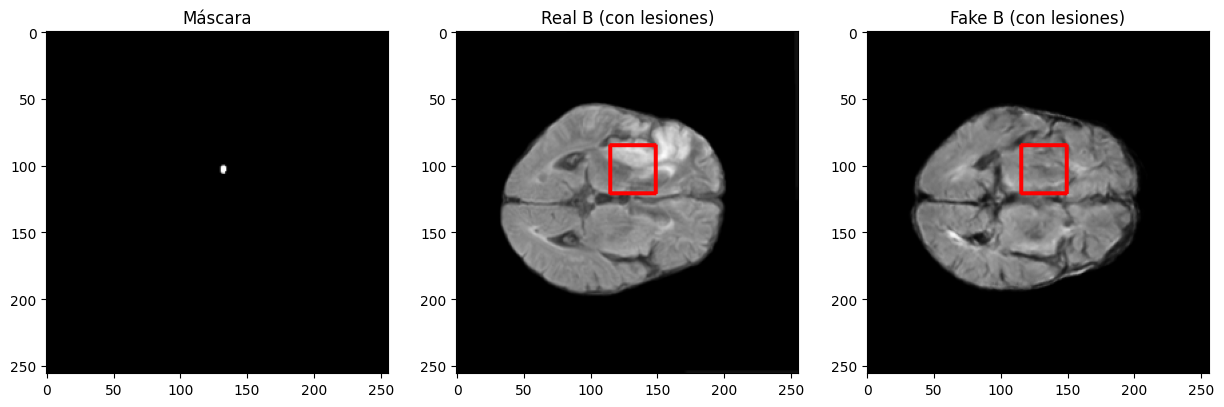

Paciente: 009, Slice 12 - SSIM: 0.453, PSNR: 13.716, MS-SSIM: 0.497


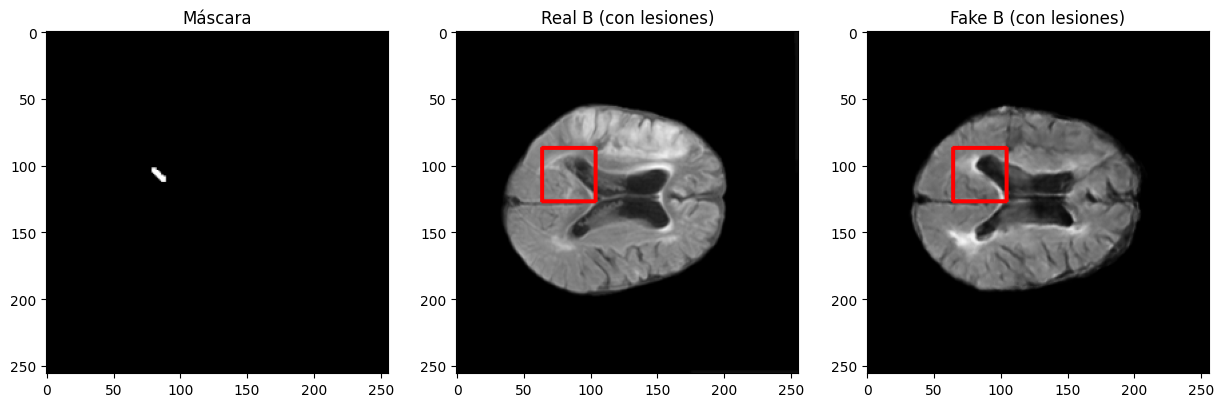

Paciente: 009, Slice 17 - SSIM: 0.428, PSNR: 10.773, MS-SSIM: 0.541


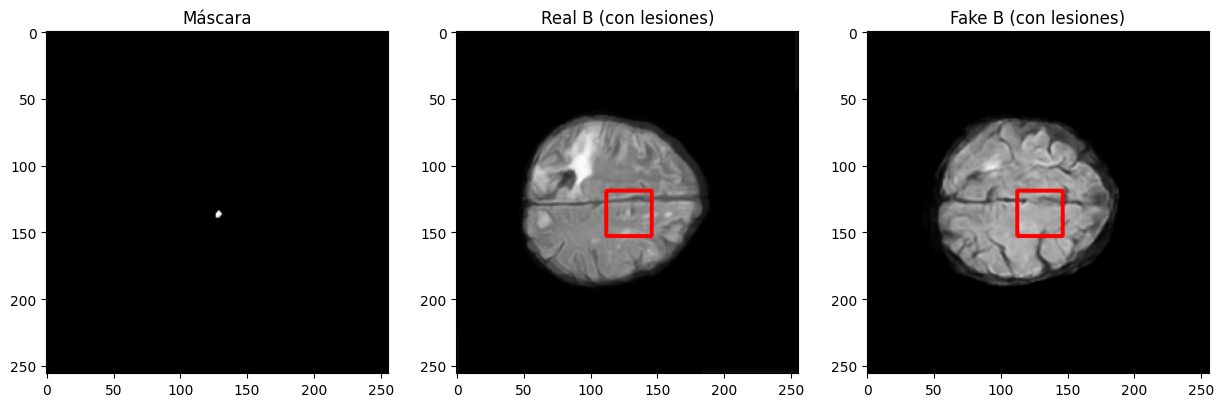

Paciente: 009, Slice 18 - SSIM: 0.370, PSNR: 16.282, MS-SSIM: 0.424


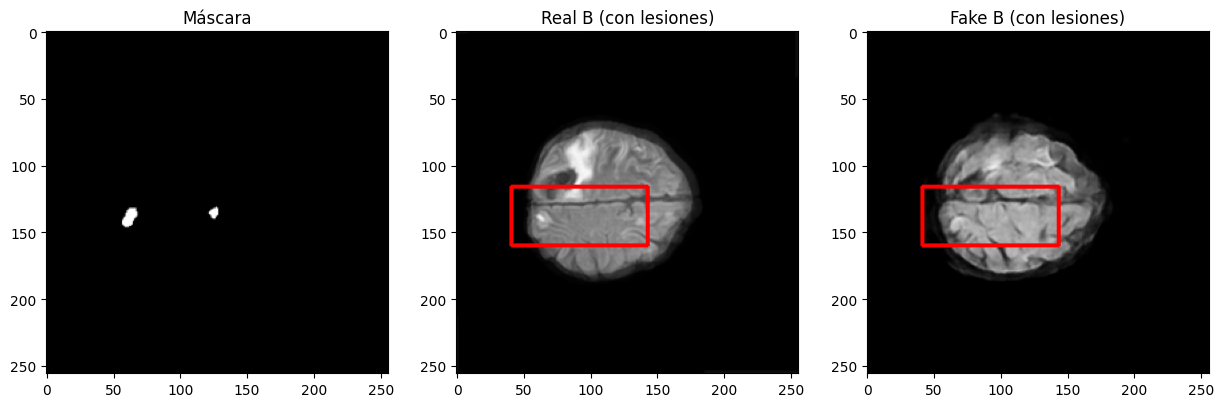

Paciente: 009, Slice 19 - SSIM: 0.524, PSNR: 16.105, MS-SSIM: 0.522


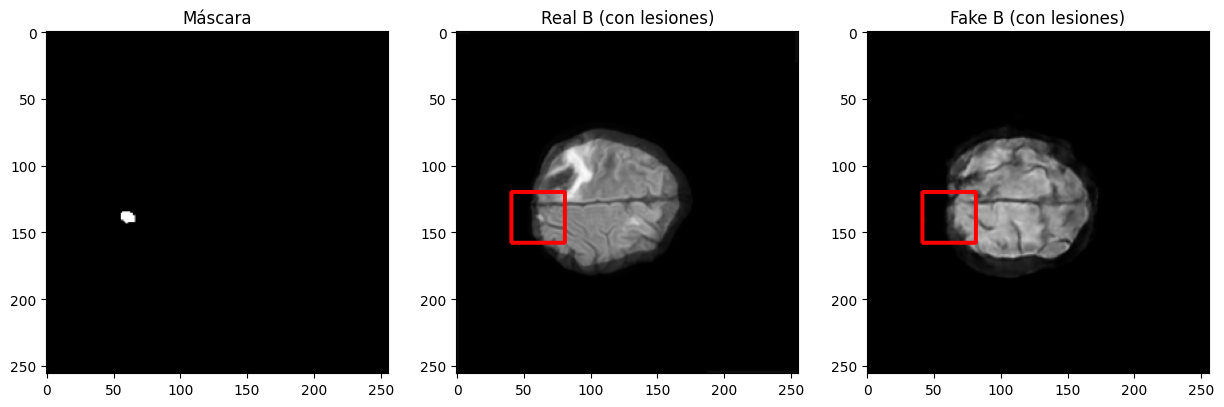

Promedio SSIM del paciente 009: 0.441
Promedio PSNR del paciente 009: 13.281
Promedio MS-SSIM del paciente 009: 0.488
Real_B ID: 012, Fake_B ID: 012, Masks ID: 012
Paciente: 012, Slice 17 - SSIM: 0.654, PSNR: 19.318, MS-SSIM: 0.580


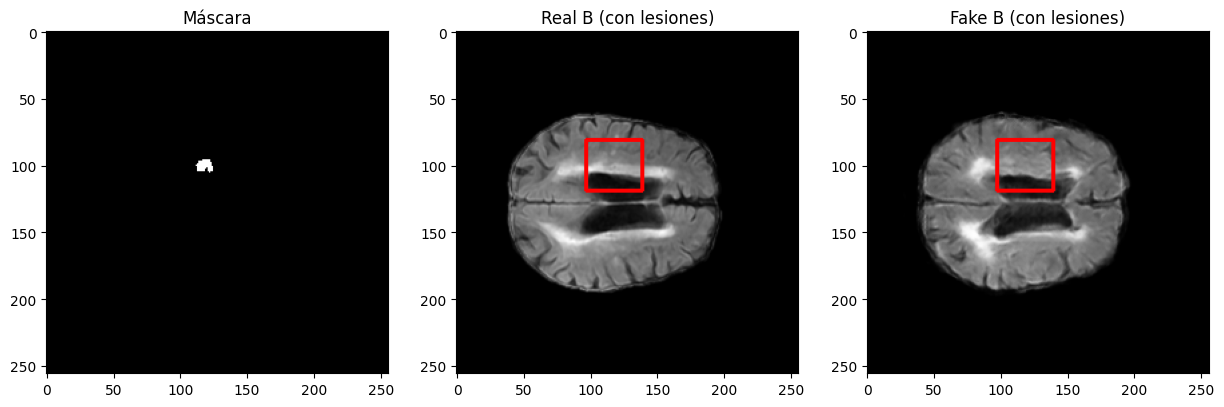

Promedio SSIM del paciente 012: 0.654
Promedio PSNR del paciente 012: 19.318
Promedio MS-SSIM del paciente 012: 0.580
Real_B ID: 015, Fake_B ID: 015, Masks ID: 015
Paciente: 015, Slice 14 - SSIM: 0.554, PSNR: 17.828, MS-SSIM: 0.617


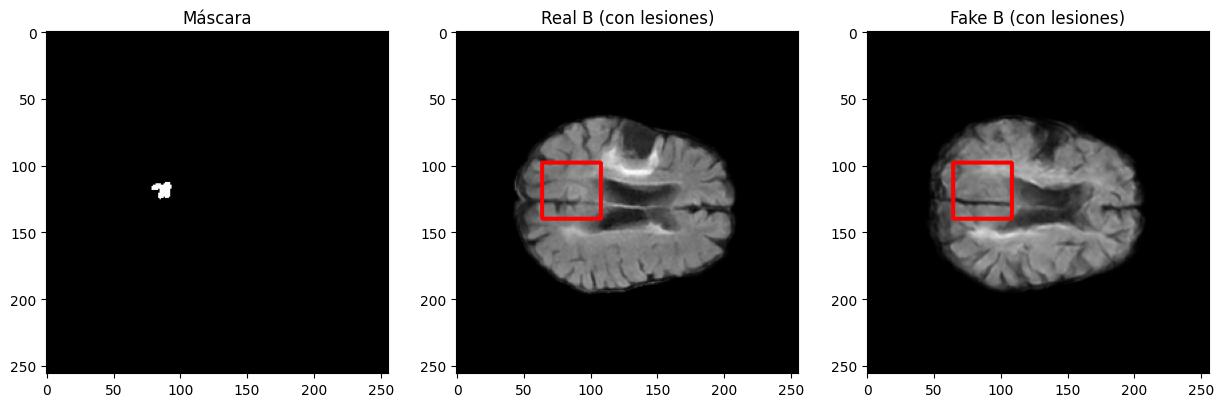

Paciente: 015, Slice 15 - SSIM: 0.520, PSNR: 19.479, MS-SSIM: 0.525


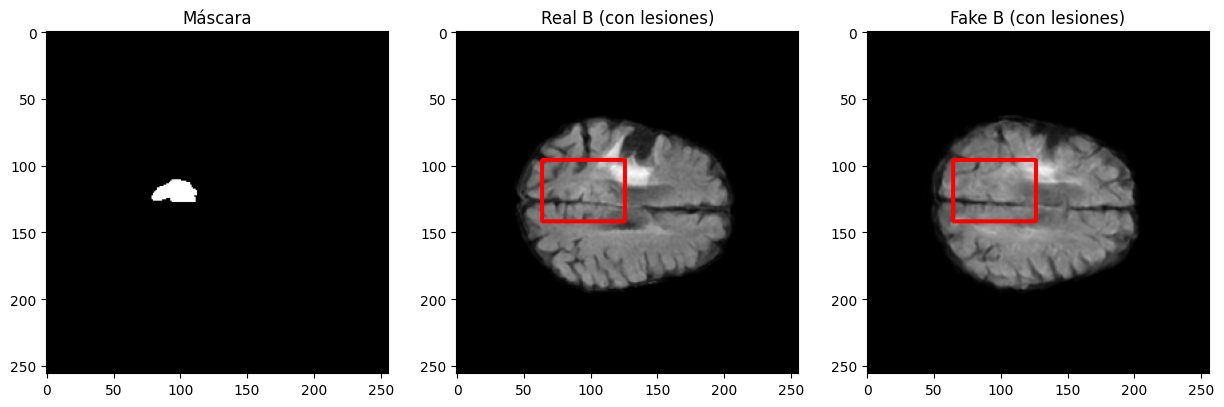

Paciente: 015, Slice 16 - SSIM: 0.367, PSNR: 15.580, MS-SSIM: 0.413


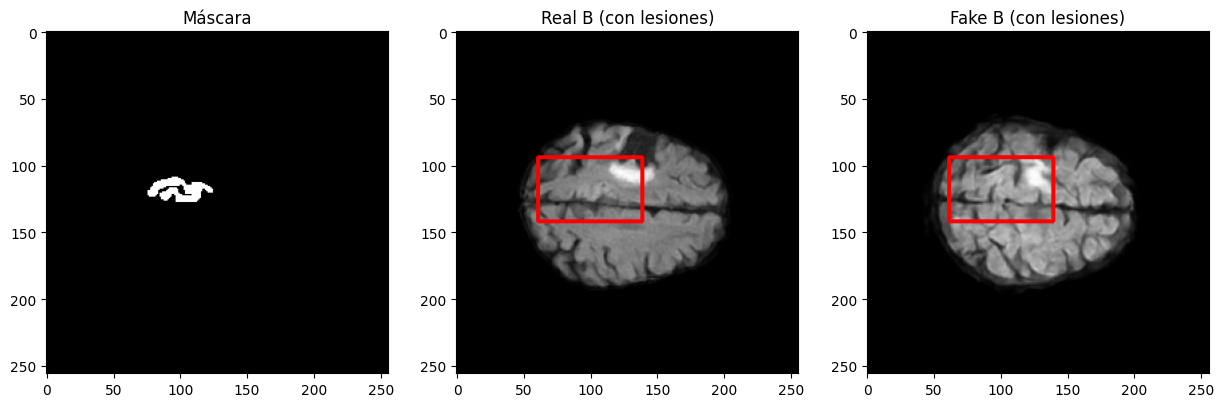

Paciente: 015, Slice 17 - SSIM: 0.319, PSNR: 11.300, MS-SSIM: 0.343


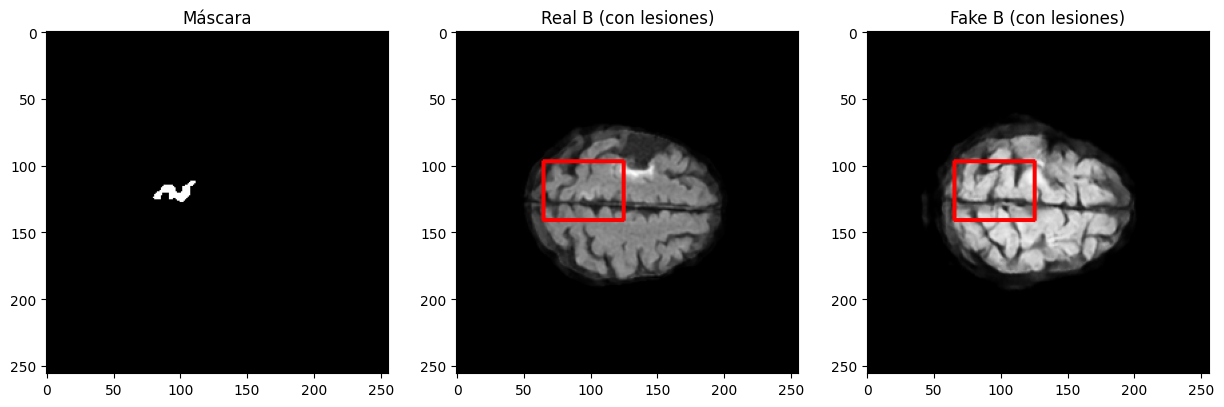

Paciente: 015, Slice 18 - SSIM: 0.280, PSNR: 9.101, MS-SSIM: 0.333


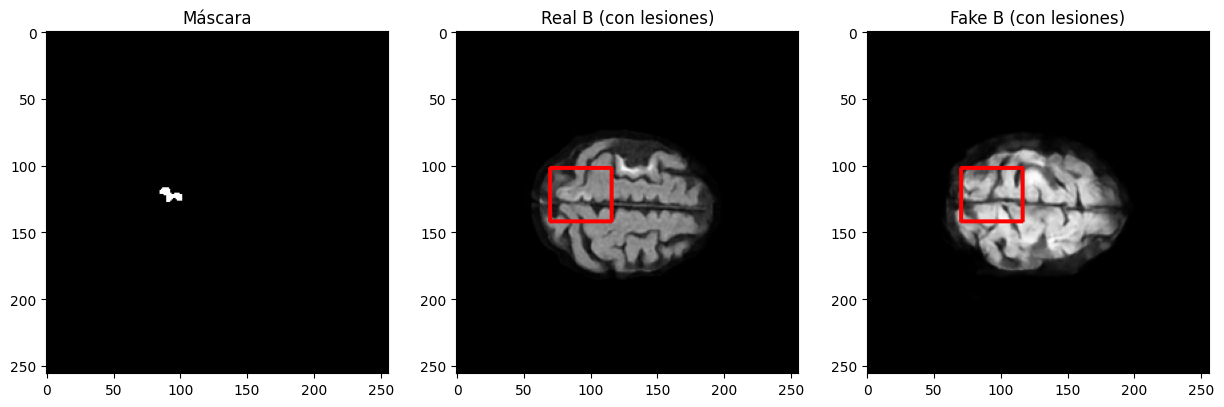

Paciente: 015, Slice 19 - SSIM: 0.393, PSNR: 14.071, MS-SSIM: 0.425


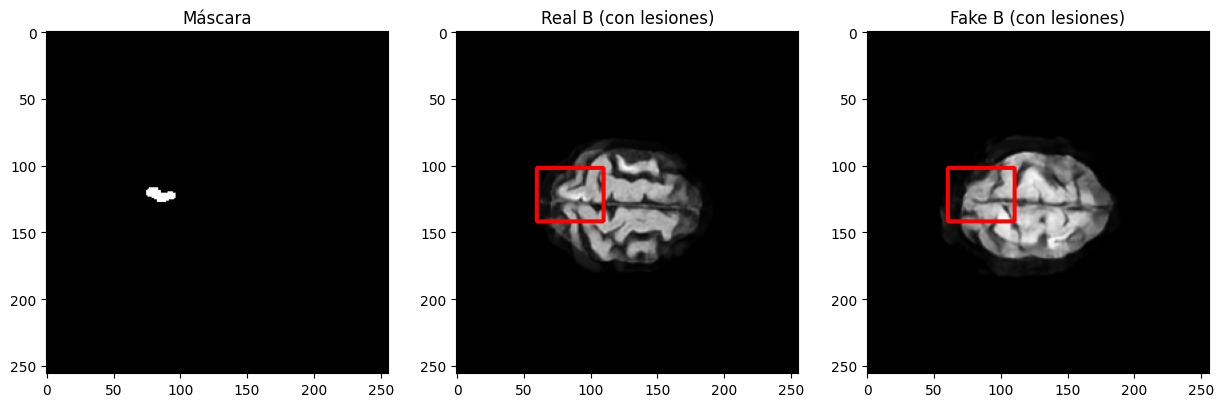

Paciente: 015, Slice 20 - SSIM: 0.392, PSNR: 14.901, MS-SSIM: 0.397


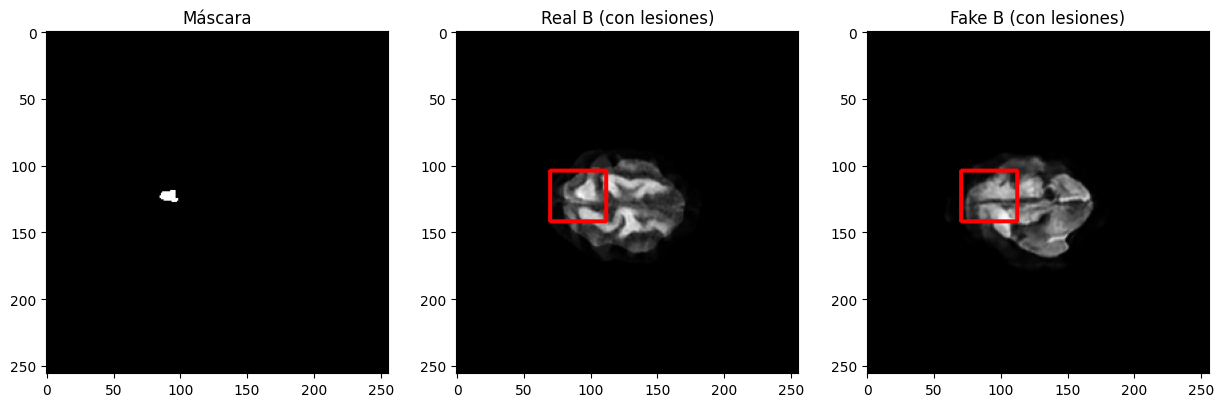

Paciente: 015, Slice 21 - SSIM: 0.410, PSNR: 14.020, MS-SSIM: 0.462


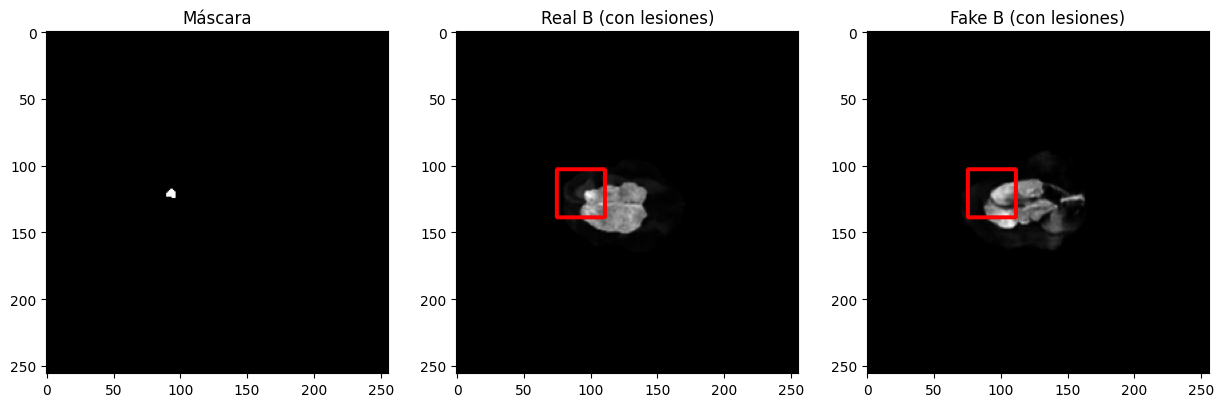

Promedio SSIM del paciente 015: 0.405
Promedio PSNR del paciente 015: 14.535
Promedio MS-SSIM del paciente 015: 0.439
Real_B ID: 018, Fake_B ID: 018, Masks ID: 018
Paciente: 018, Slice 14 - SSIM: 0.443, PSNR: 16.693, MS-SSIM: 0.433


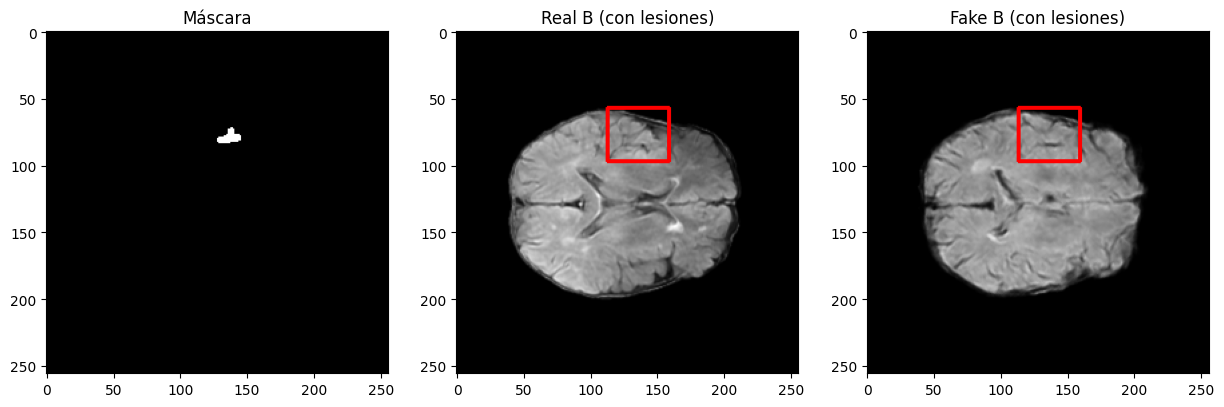

Paciente: 018, Slice 15 - SSIM: 0.471, PSNR: 14.290, MS-SSIM: 0.538


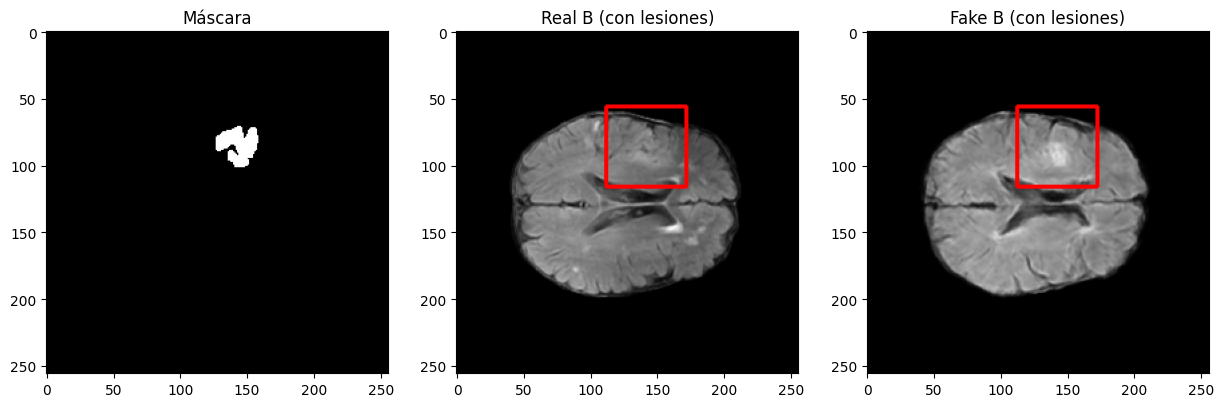

Paciente: 018, Slice 16 - SSIM: 0.478, PSNR: 18.556, MS-SSIM: 0.506


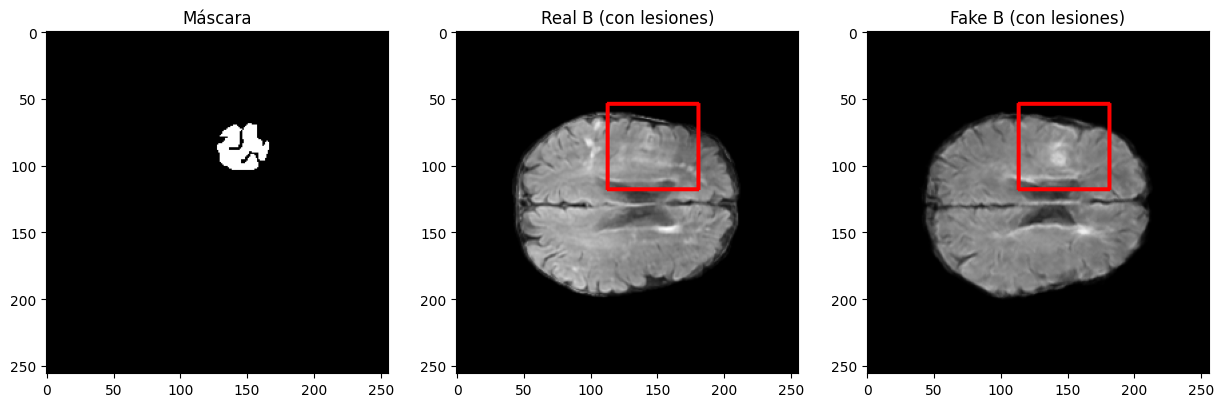

Paciente: 018, Slice 17 - SSIM: 0.522, PSNR: 18.500, MS-SSIM: 0.564


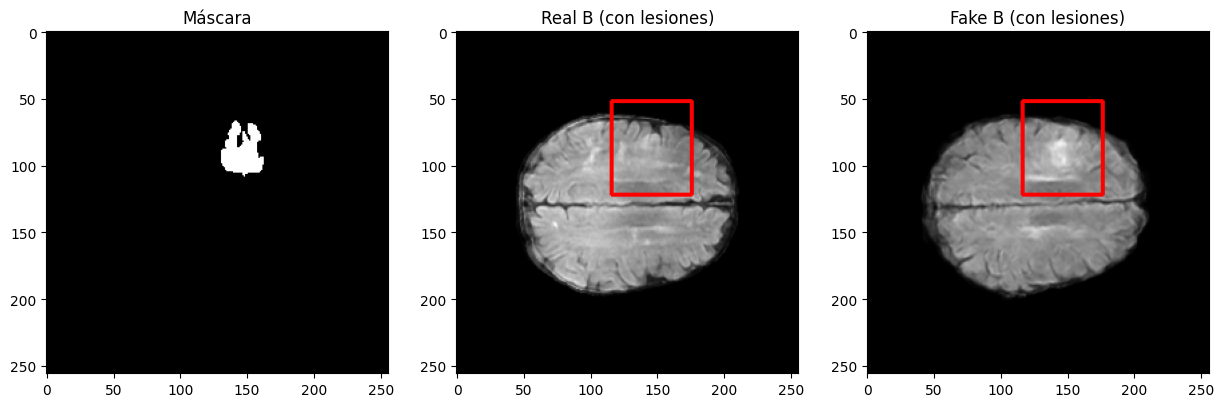

Paciente: 018, Slice 18 - SSIM: 0.465, PSNR: 16.122, MS-SSIM: 0.396


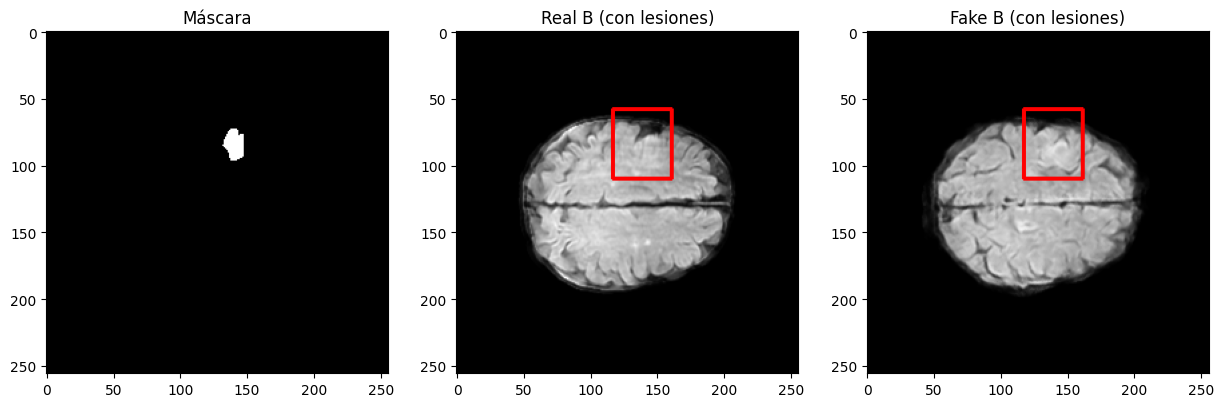

Paciente: 018, Slice 19 - SSIM: 0.405, PSNR: 15.157, MS-SSIM: 0.297


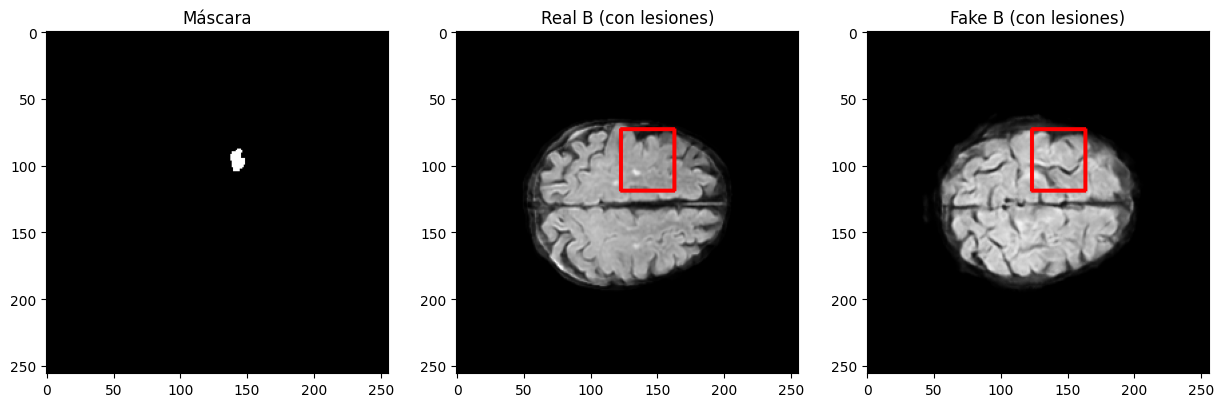

Promedio SSIM del paciente 018: 0.464
Promedio PSNR del paciente 018: 16.553
Promedio MS-SSIM del paciente 018: 0.456
Real_B ID: 019, Fake_B ID: 019, Masks ID: 019
Paciente: 019, Slice 11 - SSIM: 0.536, PSNR: 18.293, MS-SSIM: 0.521


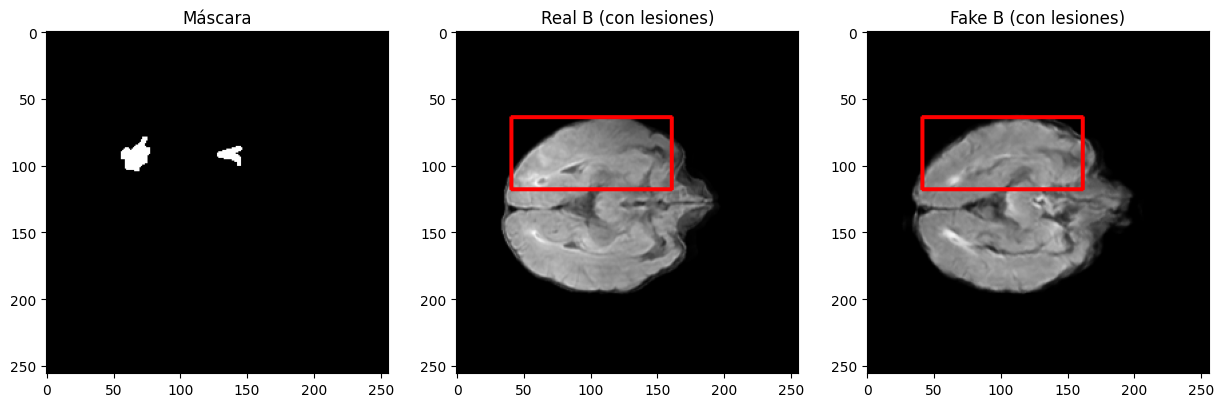

Paciente: 019, Slice 12 - SSIM: 0.603, PSNR: 19.492, MS-SSIM: 0.647


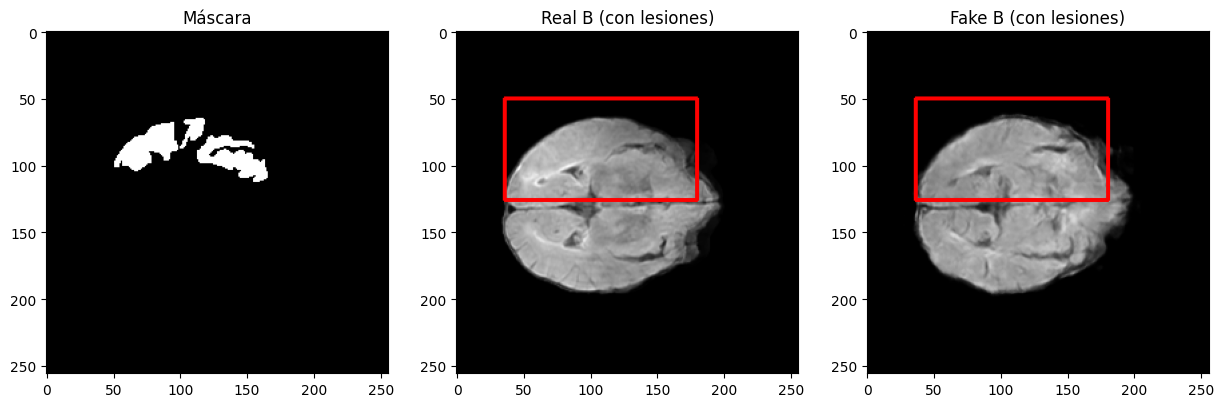

Paciente: 019, Slice 13 - SSIM: 0.564, PSNR: 18.506, MS-SSIM: 0.630


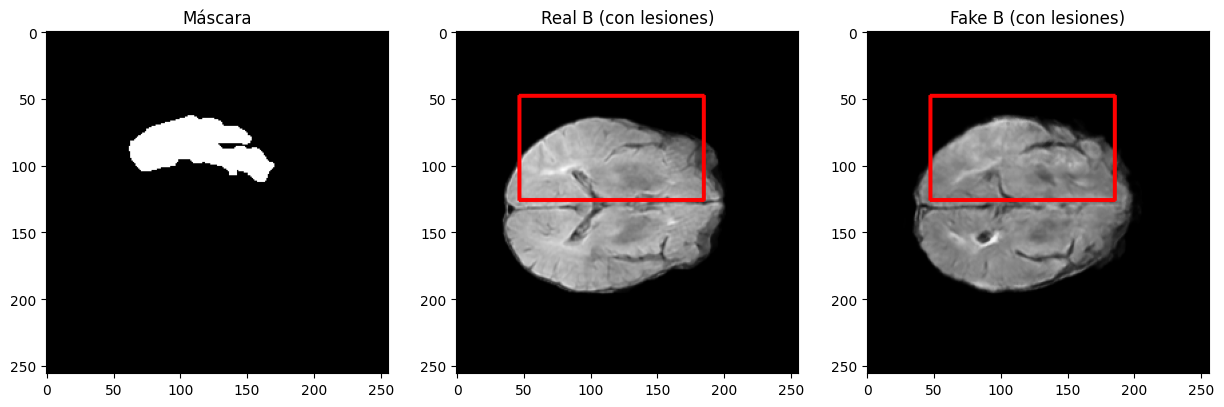

Paciente: 019, Slice 14 - SSIM: 0.526, PSNR: 17.576, MS-SSIM: 0.609


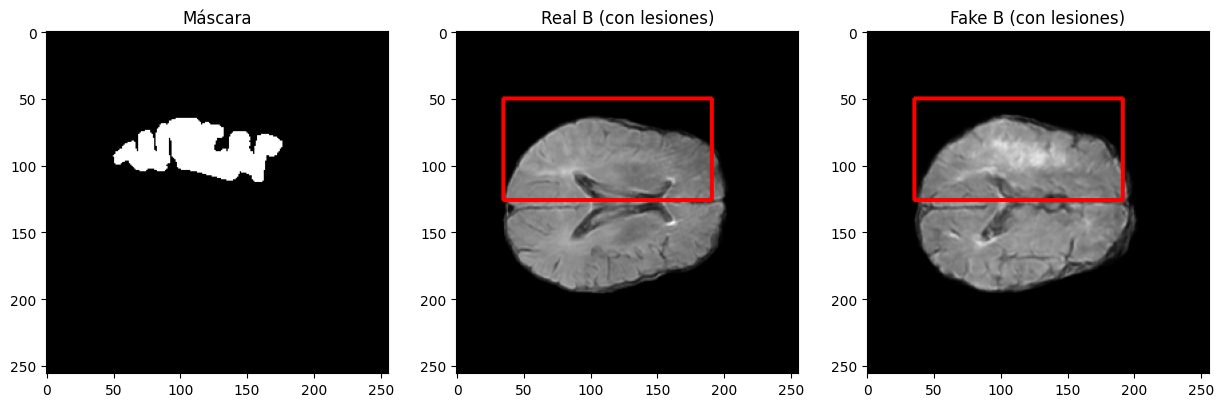

Paciente: 019, Slice 15 - SSIM: 0.554, PSNR: 18.106, MS-SSIM: 0.619


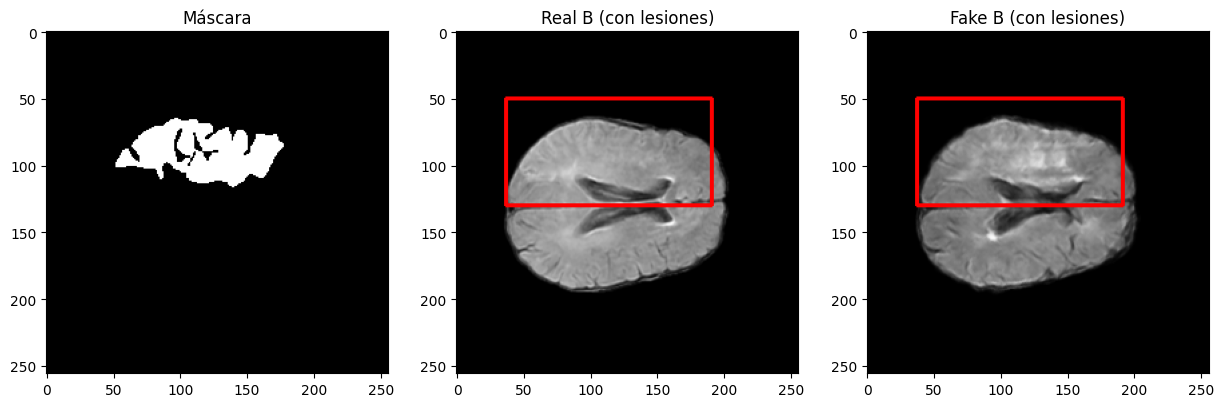

Paciente: 019, Slice 16 - SSIM: 0.525, PSNR: 15.795, MS-SSIM: 0.577


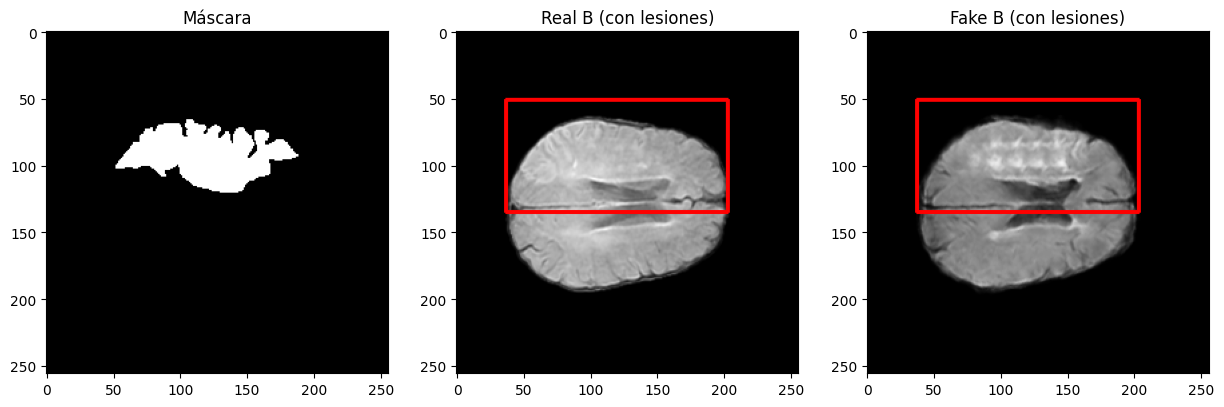

Paciente: 019, Slice 17 - SSIM: 0.546, PSNR: 15.232, MS-SSIM: 0.596


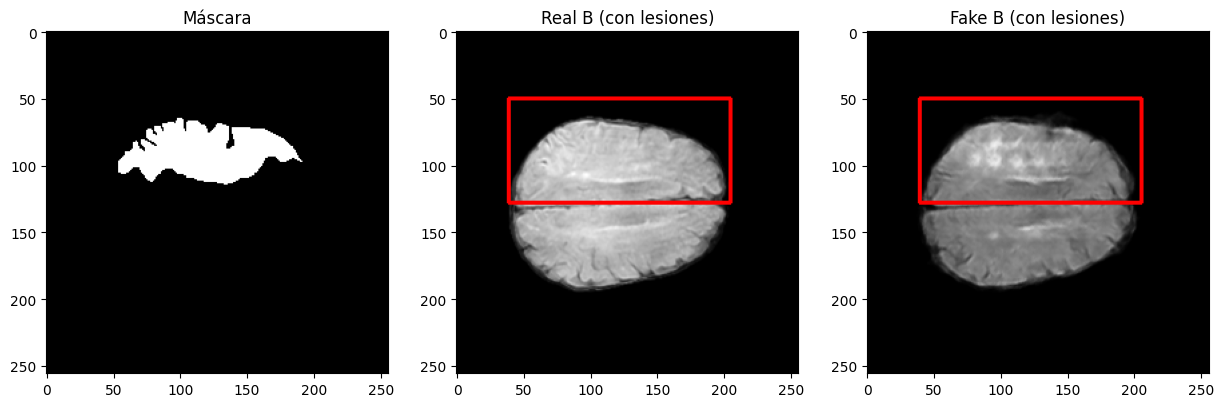

Paciente: 019, Slice 18 - SSIM: 0.575, PSNR: 17.115, MS-SSIM: 0.615


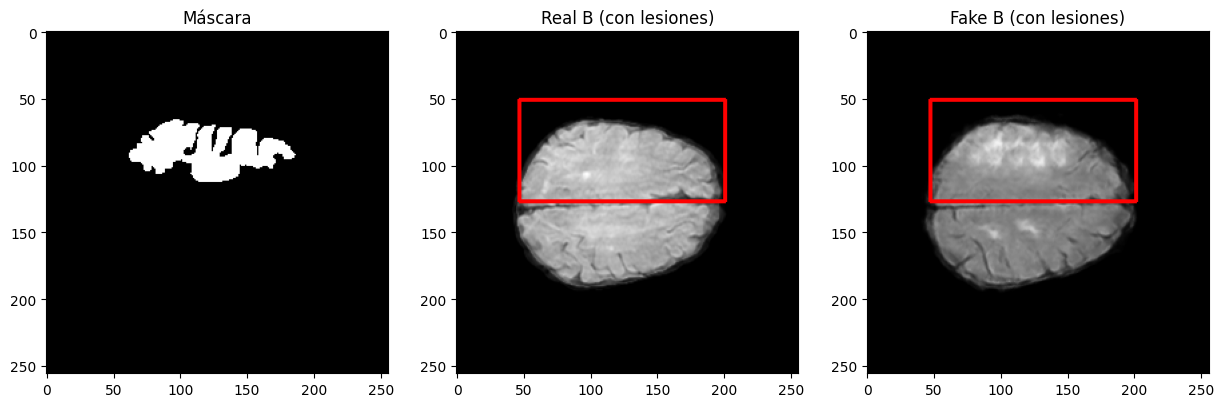

Paciente: 019, Slice 19 - SSIM: 0.543, PSNR: 14.918, MS-SSIM: 0.558


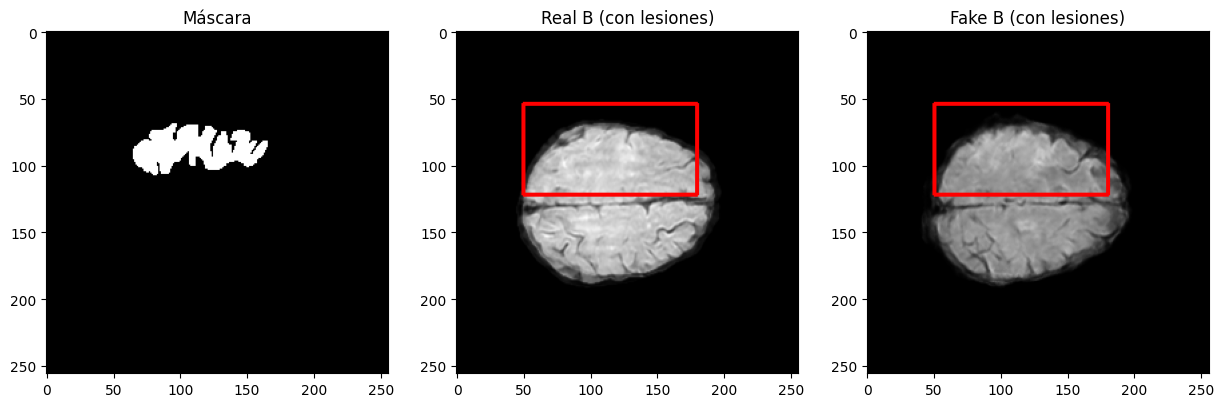

Paciente: 019, Slice 20 - SSIM: 0.476, PSNR: 14.581, MS-SSIM: 0.450


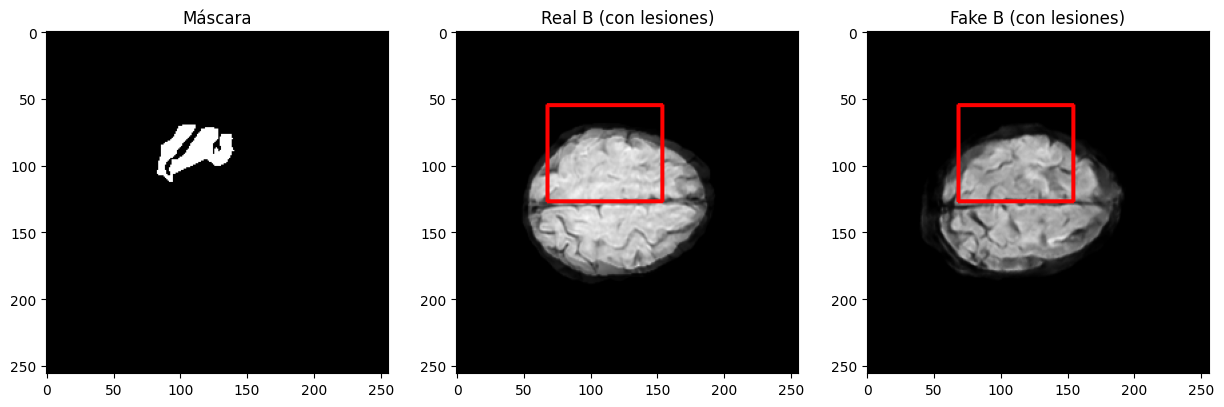

Paciente: 019, Slice 21 - SSIM: 0.476, PSNR: 15.760, MS-SSIM: 0.467


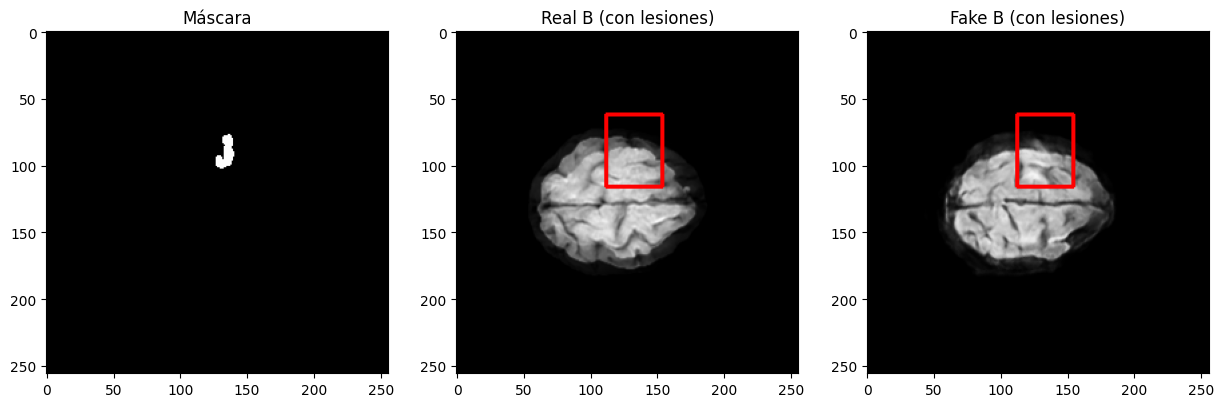

Paciente: 019, Slice 22 - SSIM: 0.457, PSNR: 13.499, MS-SSIM: 0.540


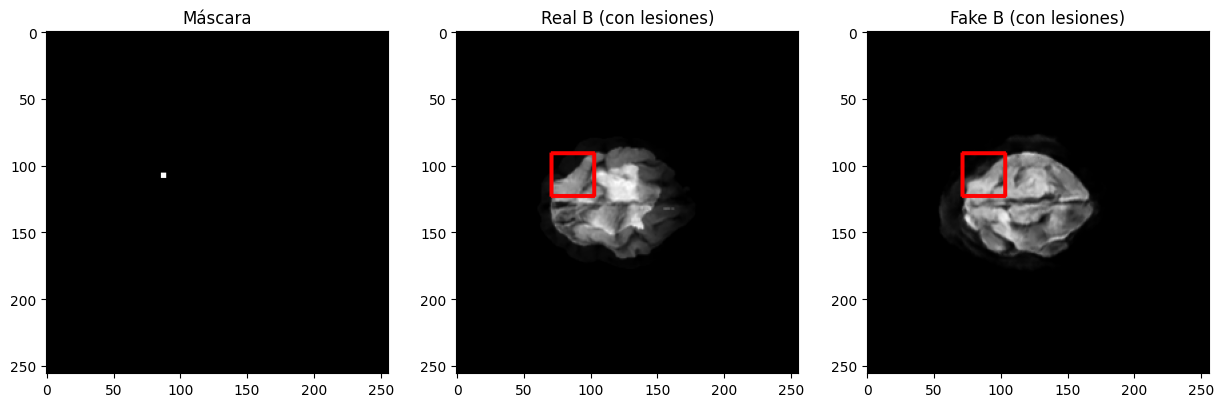

Promedio SSIM del paciente 019: 0.532
Promedio PSNR del paciente 019: 16.573
Promedio MS-SSIM del paciente 019: 0.569
Real_B ID: 020, Fake_B ID: 020, Masks ID: 020
Paciente: 020, Slice 10 - SSIM: 0.525, PSNR: 17.299, MS-SSIM: 0.537


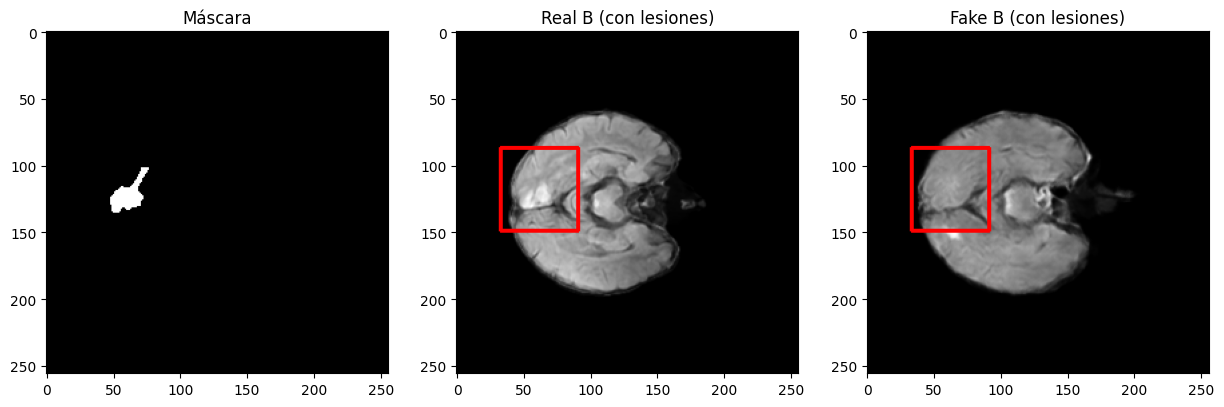

Paciente: 020, Slice 11 - SSIM: 0.481, PSNR: 16.883, MS-SSIM: 0.538


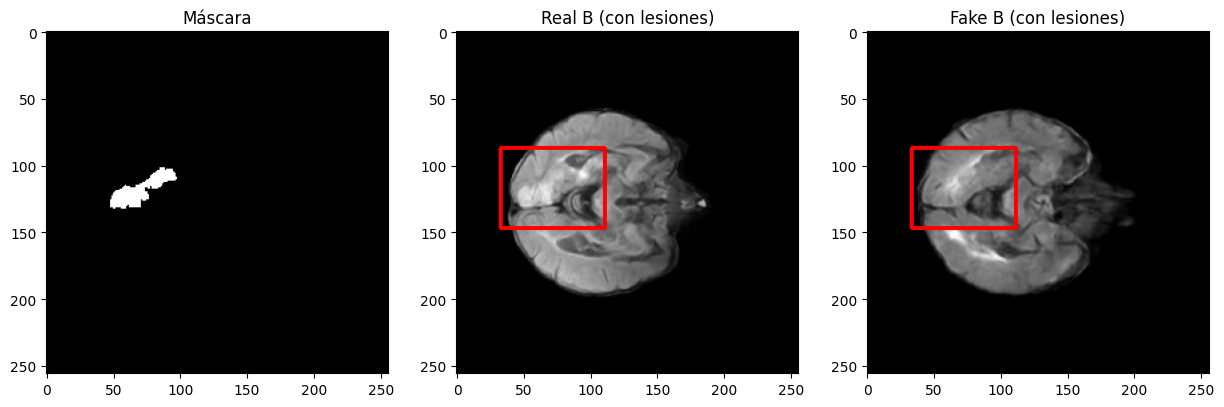

Paciente: 020, Slice 12 - SSIM: 0.470, PSNR: 17.353, MS-SSIM: 0.528


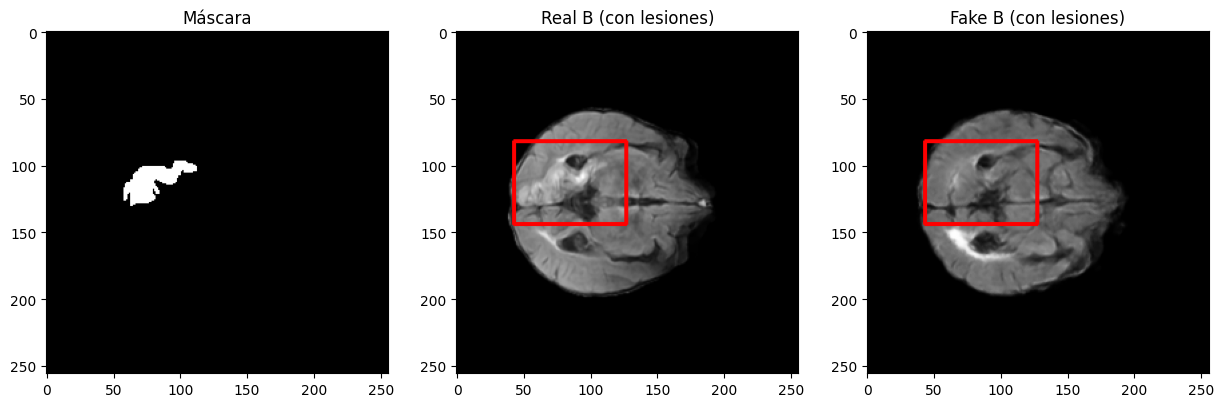

Paciente: 020, Slice 13 - SSIM: 0.507, PSNR: 19.160, MS-SSIM: 0.581


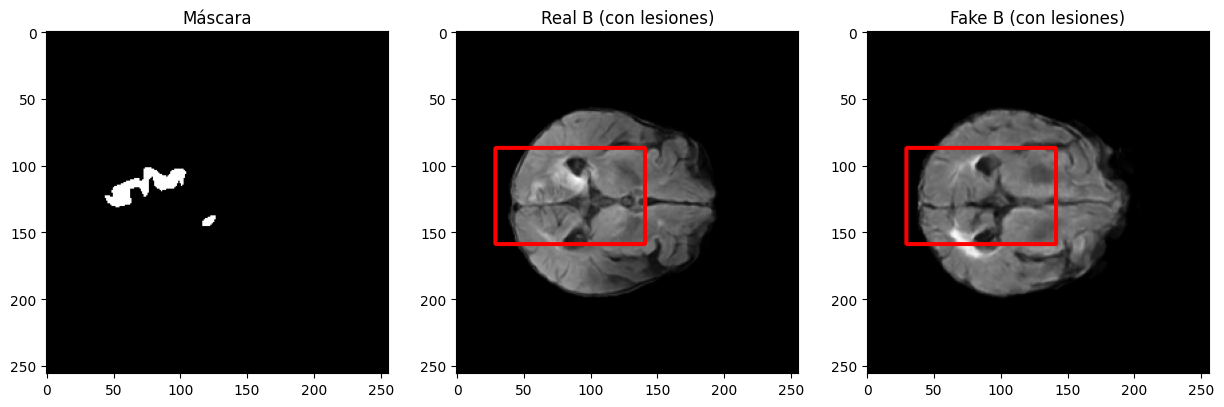

Paciente: 020, Slice 14 - SSIM: 0.450, PSNR: 17.717, MS-SSIM: 0.532


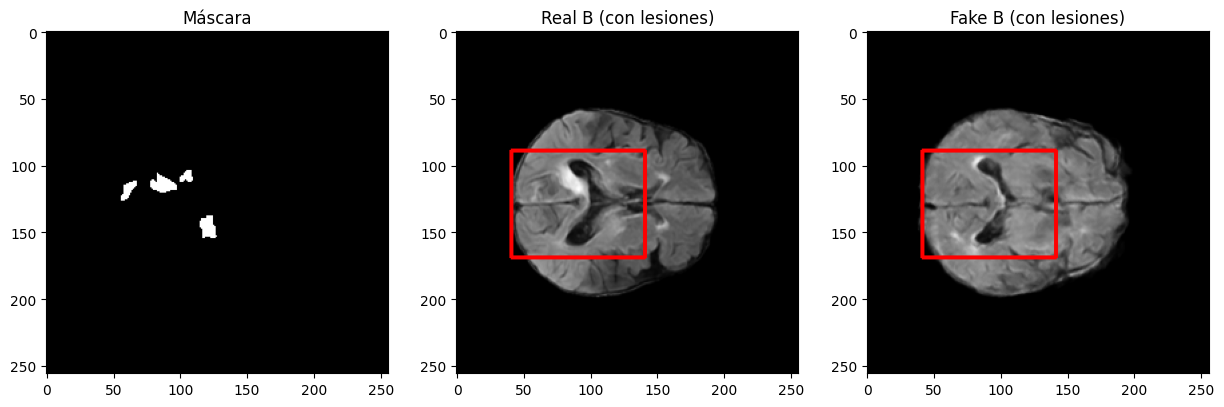

Paciente: 020, Slice 15 - SSIM: 0.457, PSNR: 17.406, MS-SSIM: 0.598


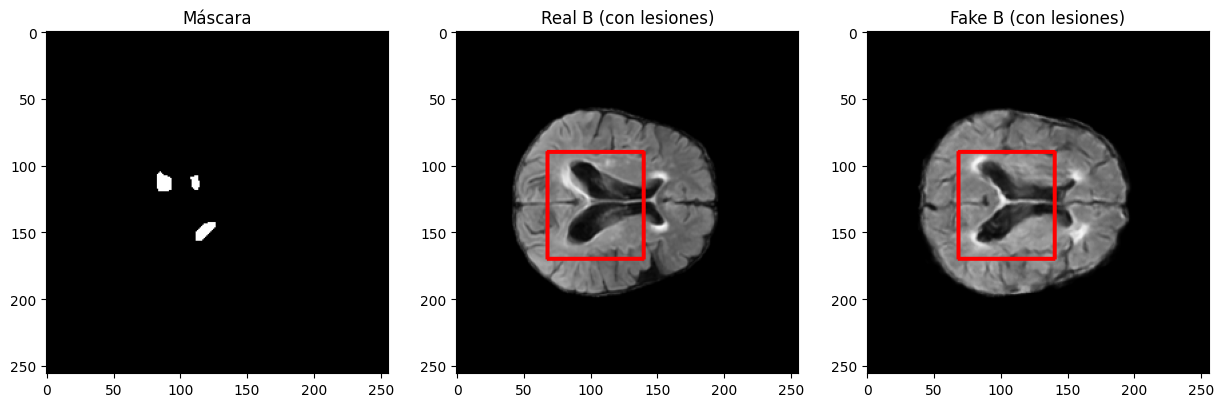

Paciente: 020, Slice 16 - SSIM: 0.494, PSNR: 16.039, MS-SSIM: 0.546


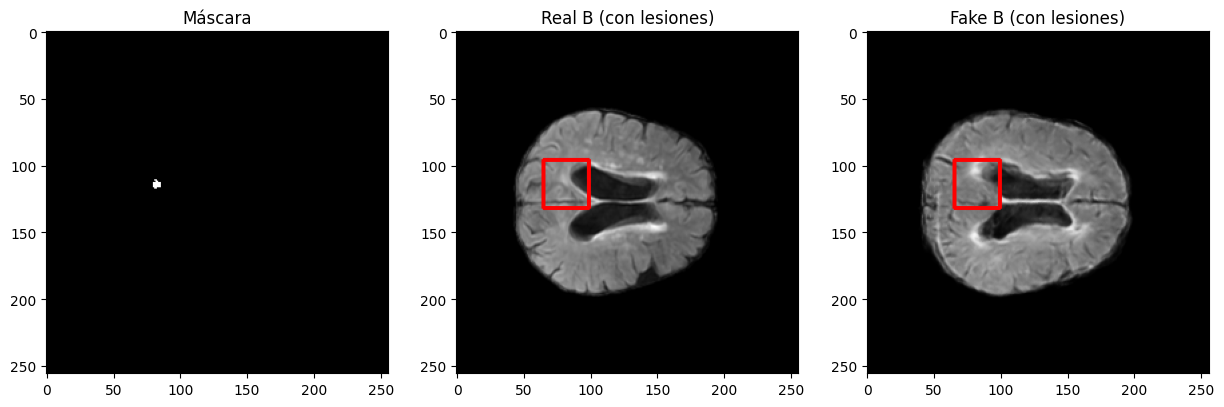

Promedio SSIM del paciente 020: 0.483
Promedio PSNR del paciente 020: 17.408
Promedio MS-SSIM del paciente 020: 0.551
Real_B ID: 021, Fake_B ID: 021, Masks ID: 021
Paciente: 021, Slice 13 - SSIM: 0.458, PSNR: 13.622, MS-SSIM: 0.546


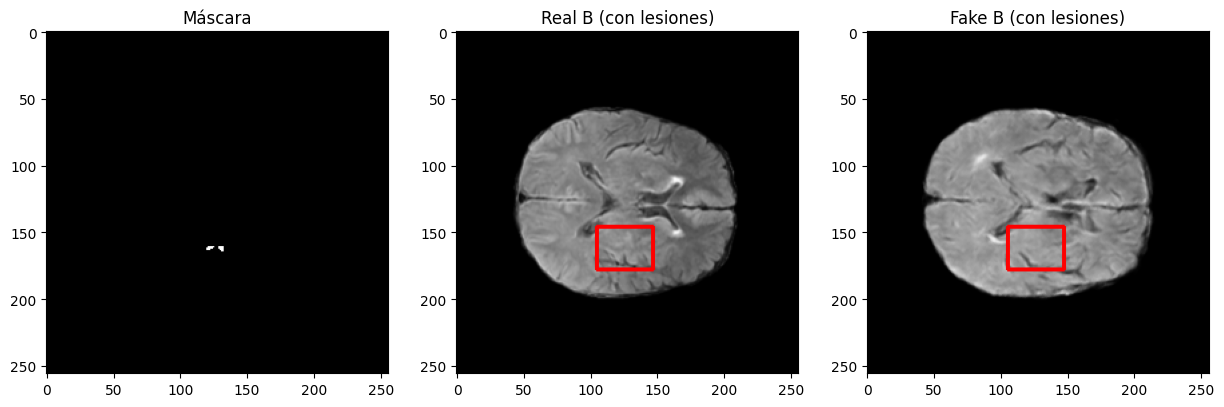

Paciente: 021, Slice 14 - SSIM: 0.446, PSNR: 16.693, MS-SSIM: 0.376


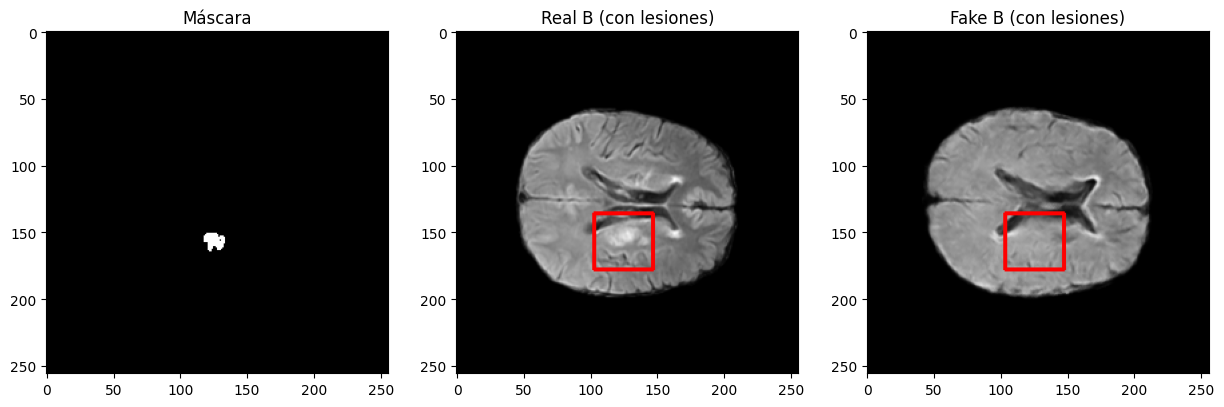

Paciente: 021, Slice 15 - SSIM: 0.527, PSNR: 18.381, MS-SSIM: 0.547


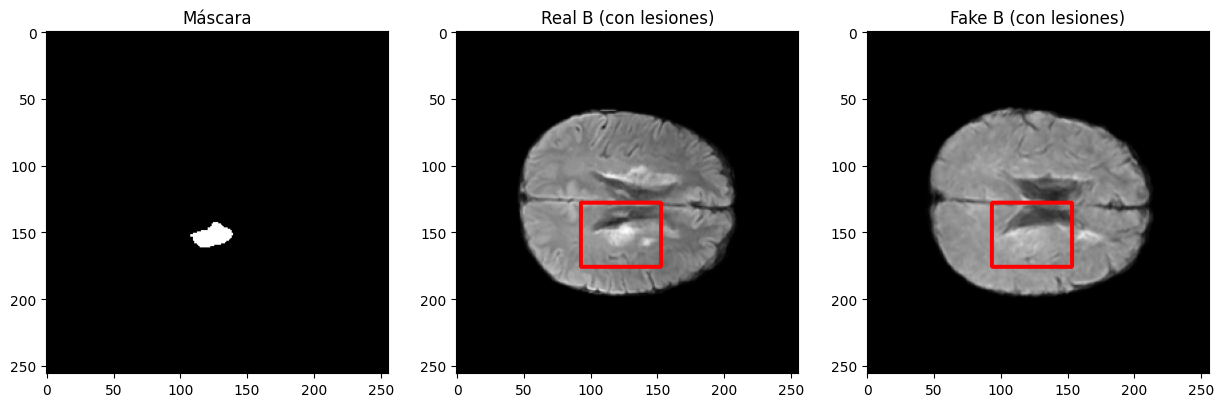

Paciente: 021, Slice 16 - SSIM: 0.545, PSNR: 12.037, MS-SSIM: 0.635


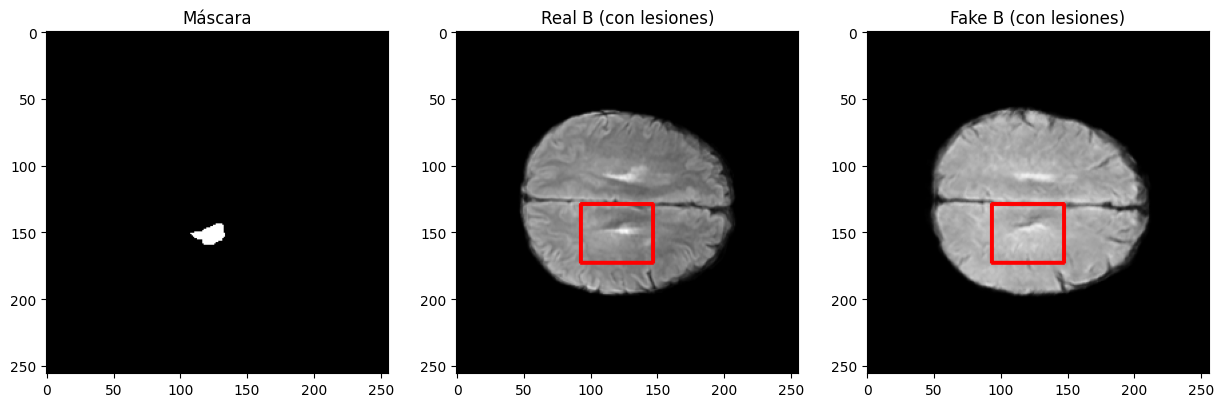

Promedio SSIM del paciente 021: 0.494
Promedio PSNR del paciente 021: 15.183
Promedio MS-SSIM del paciente 021: 0.526
Real_B ID: 023, Fake_B ID: 023, Masks ID: 023
Real_B ID: 025, Fake_B ID: 025, Masks ID: 025
Paciente: 025, Slice 6 - SSIM: 0.539, PSNR: 17.280, MS-SSIM: 0.527


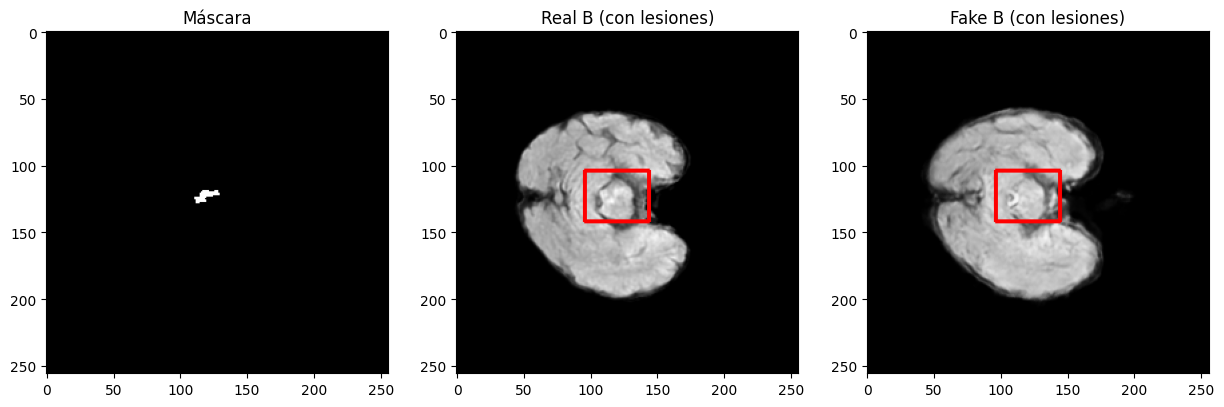

Paciente: 025, Slice 7 - SSIM: 0.563, PSNR: 15.751, MS-SSIM: 0.577


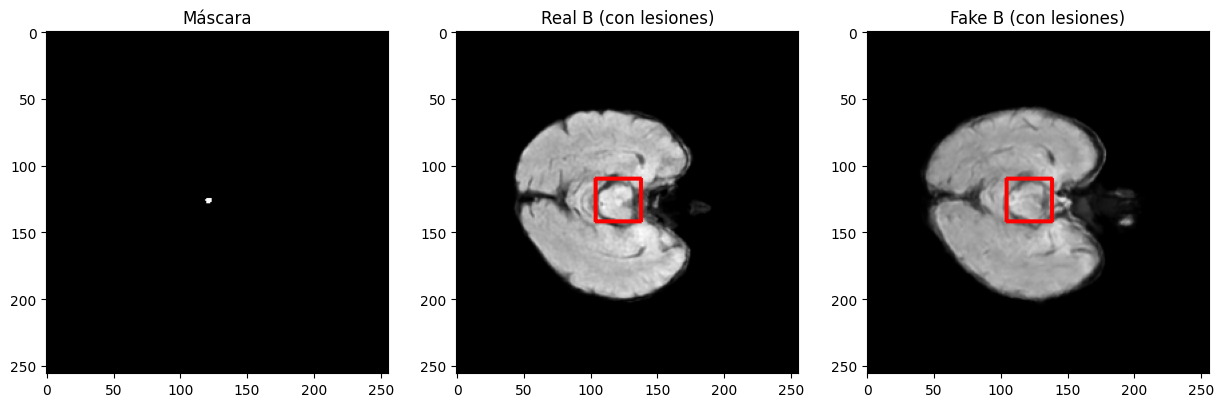

Promedio SSIM del paciente 025: 0.551
Promedio PSNR del paciente 025: 16.515
Promedio MS-SSIM del paciente 025: 0.552
Real_B ID: 037, Fake_B ID: 037, Masks ID: 037
Paciente: 037, Slice 10 - SSIM: 0.449, PSNR: 17.642, MS-SSIM: 0.575


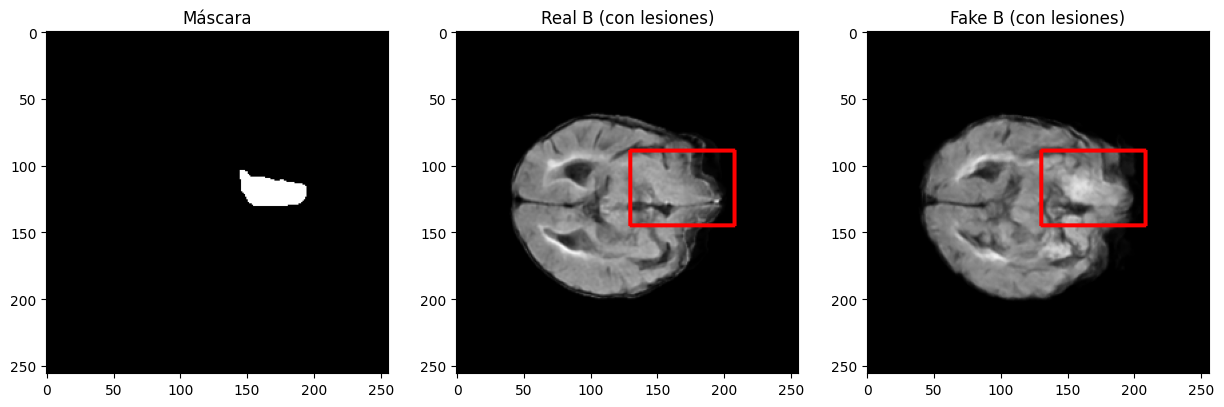

Paciente: 037, Slice 11 - SSIM: 0.497, PSNR: 19.276, MS-SSIM: 0.642


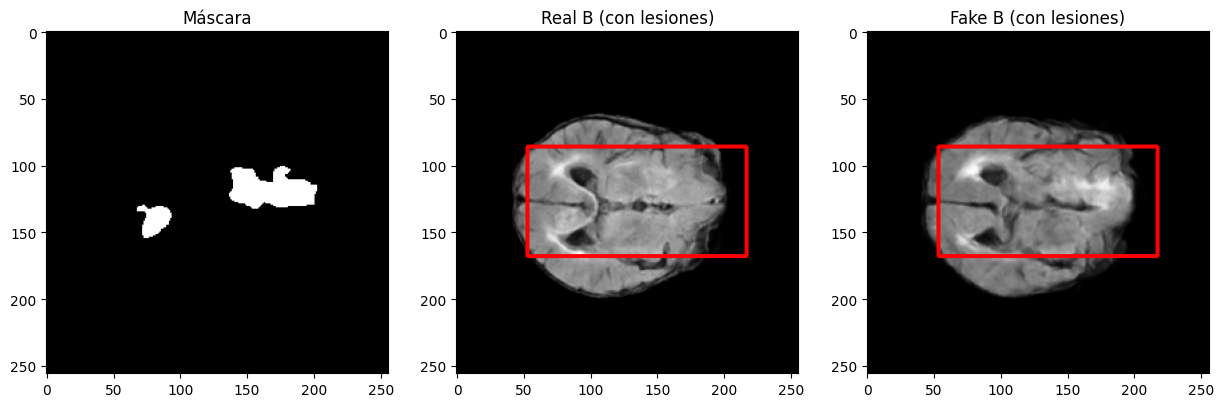

Paciente: 037, Slice 12 - SSIM: 0.534, PSNR: 19.404, MS-SSIM: 0.648


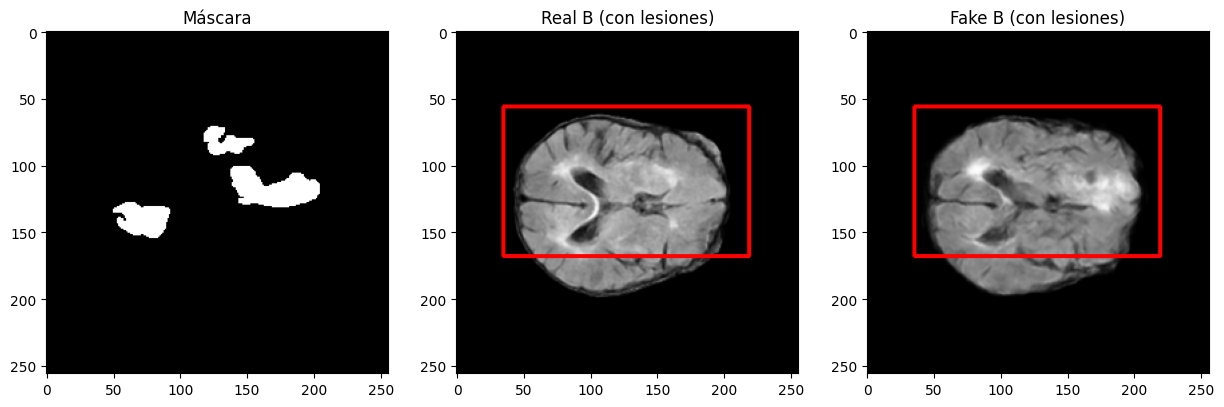

Paciente: 037, Slice 13 - SSIM: 0.516, PSNR: 19.176, MS-SSIM: 0.626


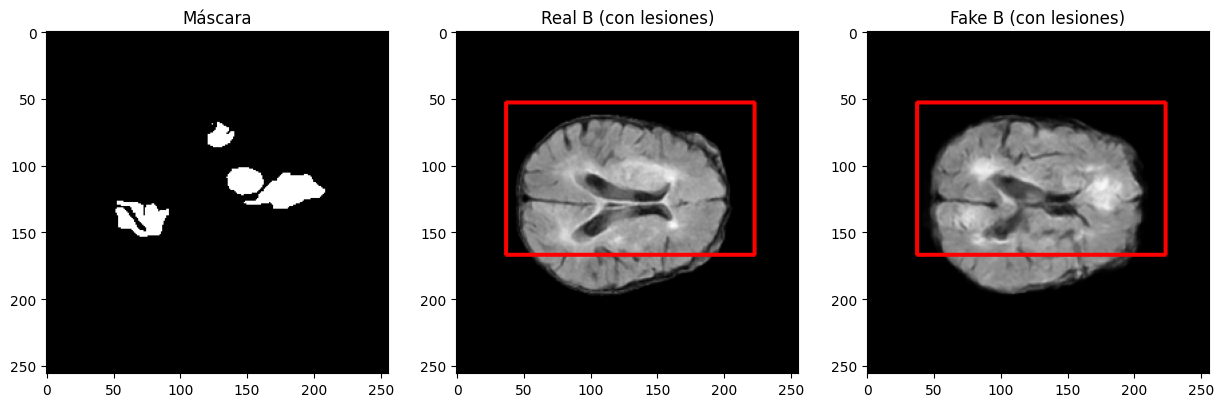

Paciente: 037, Slice 14 - SSIM: 0.525, PSNR: 19.252, MS-SSIM: 0.642


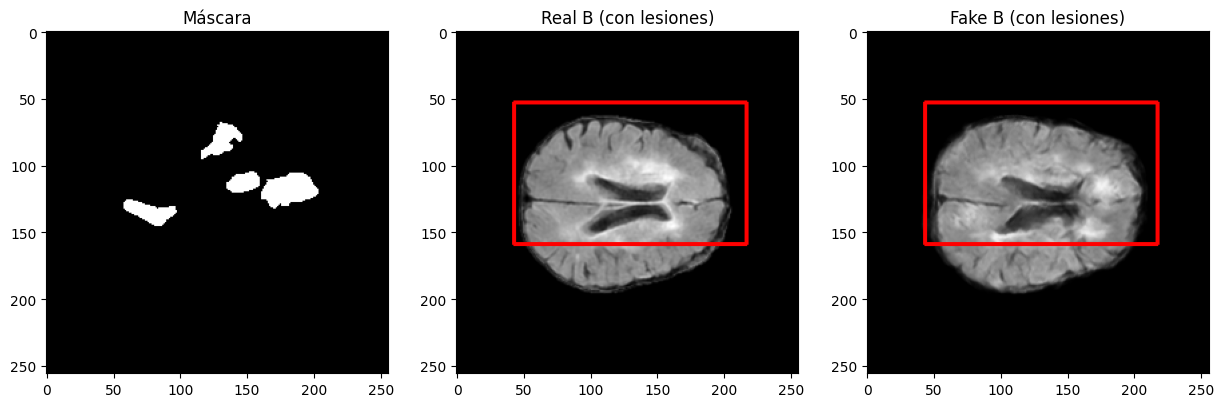

Paciente: 037, Slice 15 - SSIM: 0.546, PSNR: 20.251, MS-SSIM: 0.667


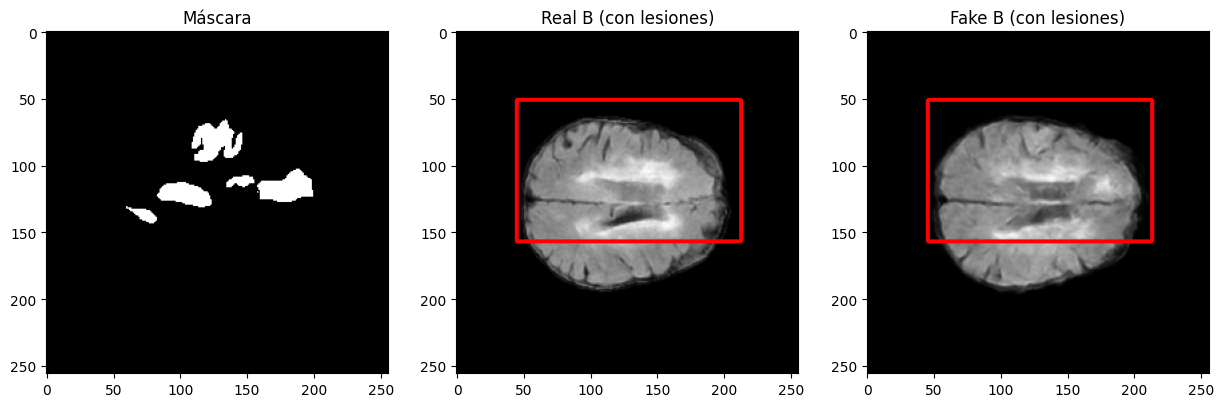

Paciente: 037, Slice 16 - SSIM: 0.493, PSNR: 19.025, MS-SSIM: 0.531


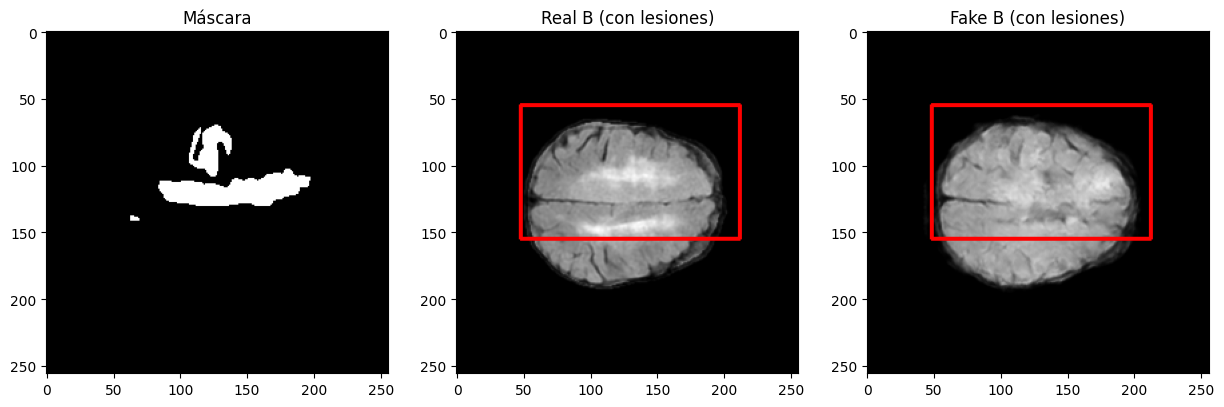

Paciente: 037, Slice 17 - SSIM: 0.429, PSNR: 17.240, MS-SSIM: 0.490


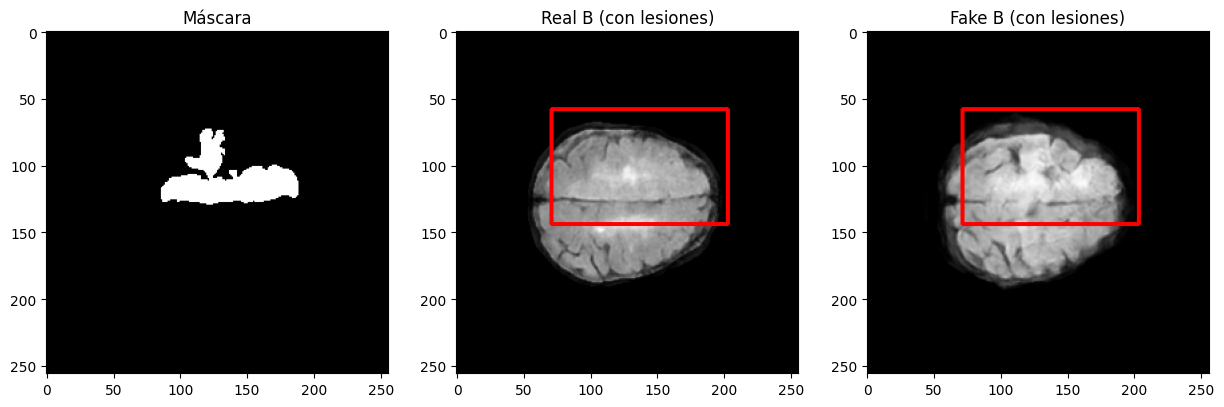

Paciente: 037, Slice 18 - SSIM: 0.464, PSNR: 17.230, MS-SSIM: 0.535


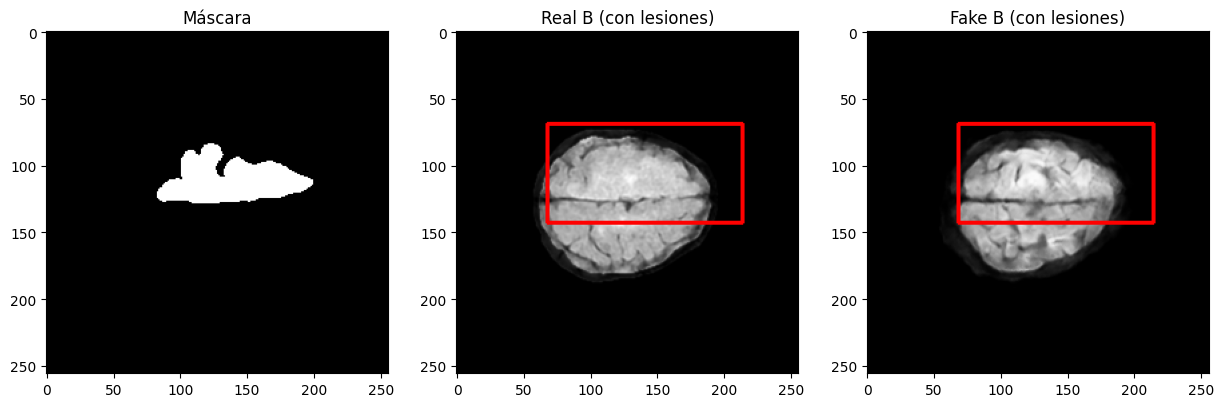

Paciente: 037, Slice 19 - SSIM: 0.472, PSNR: 14.844, MS-SSIM: 0.511


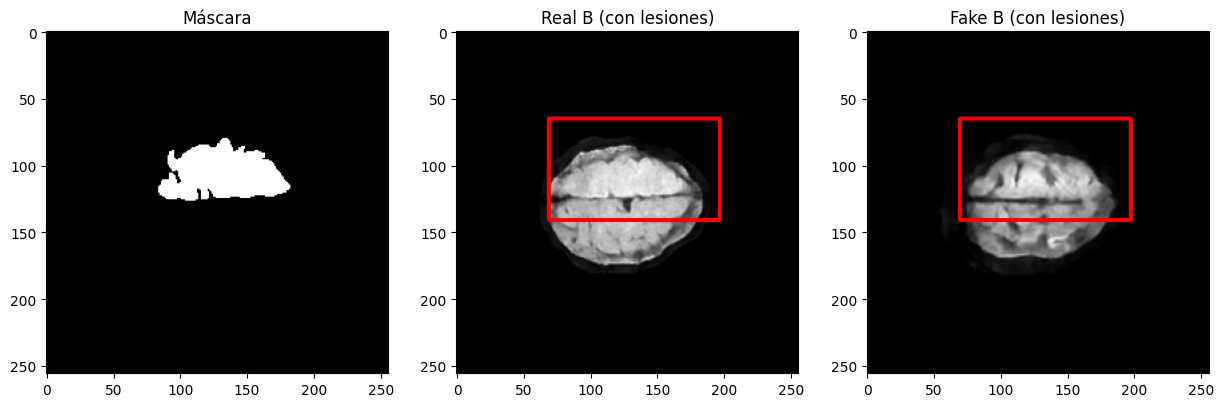

Paciente: 037, Slice 20 - SSIM: 0.489, PSNR: 14.508, MS-SSIM: 0.569


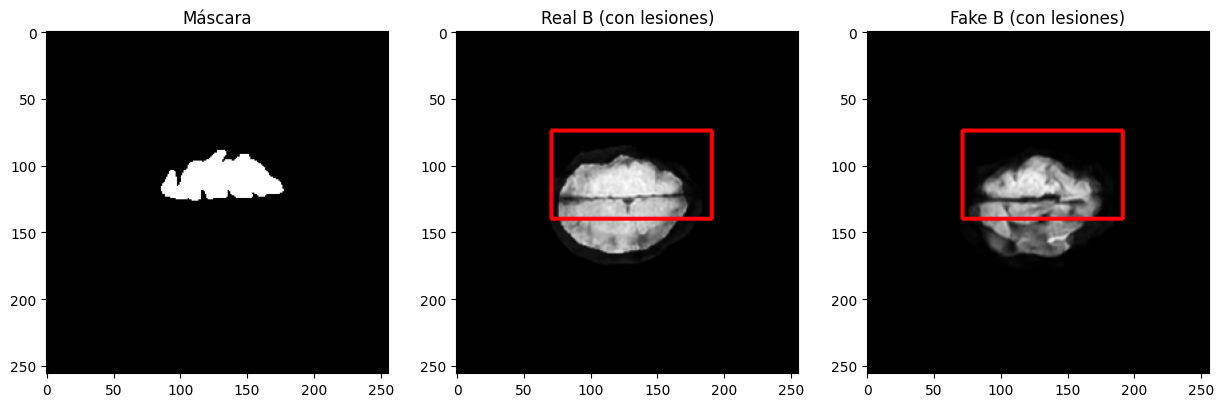

Paciente: 037, Slice 21 - SSIM: 0.560, PSNR: 14.333, MS-SSIM: 0.565


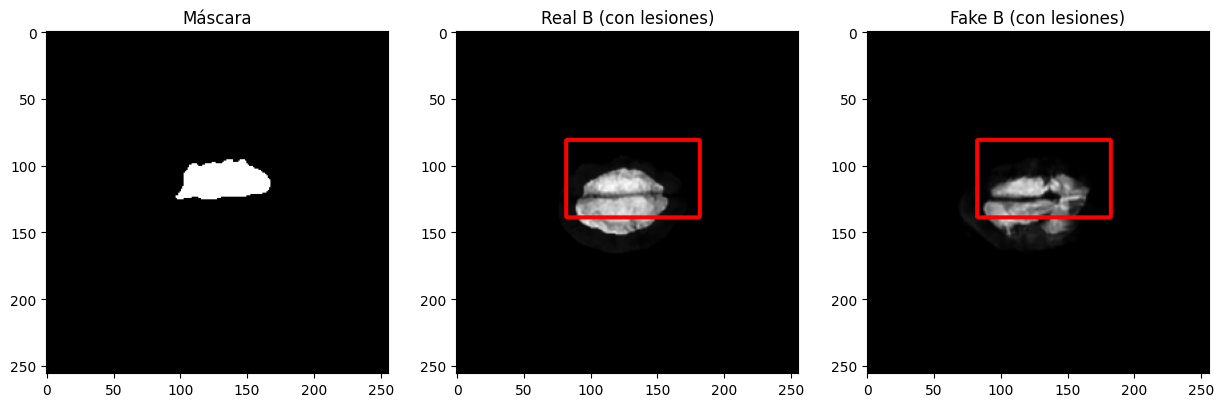

Paciente: 037, Slice 22 - SSIM: 0.427, PSNR: 16.032, MS-SSIM: 0.543


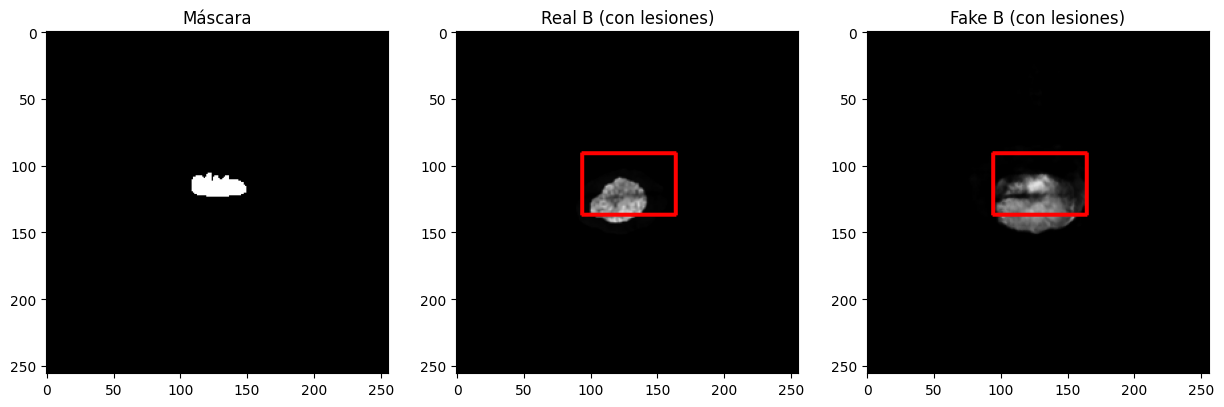

Promedio SSIM del paciente 037: 0.492
Promedio PSNR del paciente 037: 17.555
Promedio MS-SSIM del paciente 037: 0.580

SSIM Promedio por Paciente (Lesiones): 0.505, Desviación Estándar SSIM por Paciente (Lesiones): 0.063
PSNR Promedio por Paciente (Lesiones): 16.103, Desviación Estándar PSNR por Paciente (Lesiones): 1.764
MS-SSIM Promedio por Paciente (Lesiones): 0.513, Desviación Estándar MS-SSIM por Paciente (Lesiones): 0.064


In [12]:
# Lista de pacientes de interés
pacientes_interes_FLAIR = ['002', '006', '007', '009', '012', '015', '018', '019', '020', '021', '023', '025', '037']

# Obtener la lista de carpetas de pacientes
carpetas_pacientes_real_B = sorted(Path(ruta_real_B).glob("*"))
carpetas_pacientes_fake_B = sorted(Path(ruta_fake_B).glob("*"))
carpetas_pacientes_masks = sorted(Path(ruta_masks).glob("*"))

ms_ssim = MultiScaleStructuralSimilarityIndexMeasure(data_range=1.0, kernel_size=5, betas=(0.1, 0.3, 0.5))
ssim_values_por_paciente = []
psnr_values_por_paciente = []
ms_ssim_values_por_paciente = []

for carpeta_paciente_real_B, carpeta_paciente_fake_B, carpeta_paciente_masks in zip(carpetas_pacientes_real_B, carpetas_pacientes_fake_B, carpetas_pacientes_masks):
    id_paciente_real_B = carpeta_paciente_real_B.stem
    id_paciente_fake_B = carpeta_paciente_fake_B.stem
    id_paciente_masks = carpeta_paciente_masks.stem
    
    # Filtrar solo los pacientes de interés
    if id_paciente_real_B not in pacientes_interes_FLAIR:
        continue
    
    # Imprimir los IDs para depuración
    print(f"Real_B ID: {id_paciente_real_B}, Fake_B ID: {id_paciente_fake_B}, Masks ID: {id_paciente_masks}")

    # Asegurarnos de que los IDs de los pacientes coincidan
    assert id_paciente_real_B == id_paciente_fake_B == id_paciente_masks, "Los IDs de los pacientes no coinciden"

    archivos_real_B = sorted(carpeta_paciente_real_B.glob("*.png"))
    archivos_fake_B = sorted(carpeta_paciente_fake_B.glob("*.png"))
    archivos_masks = sorted(carpeta_paciente_masks.glob("*.png"))

    imagenes_real_B = [Image.open(str(f)) for f in archivos_real_B]
    imagenes_fake_B = [Image.open(str(f)) for f in archivos_fake_B]
    imagenes_masks = [plt.imread(str(f)) for f in archivos_masks]

    # Verificar que todas las imágenes tengan el tamaño esperado
    for i, img in enumerate(imagenes_real_B):
        assert img.size == (256, 256), f"Image {i} in real_B has size {img.size}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.size == (256, 256), f"Image {i} in fake_B has size {img.size}"
    for i, img in enumerate(imagenes_masks):
        assert img.shape == (256, 256), f"Image {i} in masks has shape {img.shape}"

    ssim_values_lesion_paciente = []
    psnr_values_lesion_paciente = []
    ms_ssim_values_lesion_paciente = []

    tiene_lesiones = False

    for idx, (img_real_B, img_fake_B, img_mask) in enumerate(zip(imagenes_real_B, imagenes_fake_B, imagenes_masks)):
        if np.any(img_mask):  # Si hay alguna lesión en la máscara
            tiene_lesiones = True
            lesion_coords = np.where(img_mask)  # Coordenadas de las lesiones
            y_min, y_max = lesion_coords[0].min(), lesion_coords[0].max()
            x_min, x_max = lesion_coords[1].min(), lesion_coords[1].max()

            # Asegurar que el tamaño mínimo del recorte sea suficientemente grande para contexto
            min_context = 30  # Tamaño mínimo del contexto
            y_size = max(y_max - y_min + min_context, min_context)
            x_size = max(x_max - x_min + min_context, min_context)

            # Calcular el centro y las coordenadas del rectángulo
            y_center = (y_min + y_max) // 2
            x_center = (x_min + x_max) // 2
            y_start = max(0, y_center - y_size // 2)
            y_end = min(img_real_B.size[1], y_center + y_size // 2)
            x_start = max(0, x_center - x_size // 2)
            x_end = min(img_real_B.size[0], x_center + x_size // 2)

            # Extraer las regiones de interés
            real_lesion_region = img_real_B.crop((x_start, y_start, x_end, y_end))
            fake_lesion_region = img_fake_B.crop((x_start, y_start, x_end, y_end))

            # Redimensionar las regiones para que sean compatibles con MS-SSIM
            real_lesion_region_resized = real_lesion_region.resize((160, 160), Image.BICUBIC)
            fake_lesion_region_resized = fake_lesion_region.resize((160, 160), Image.BICUBIC)

            # Convertir las imágenes a tensores
            real_lesion_tensor = to_tensor(real_lesion_region_resized).unsqueeze(0)
            fake_lesion_tensor = to_tensor(fake_lesion_region_resized).unsqueeze(0)

            # Calcular MS-SSIM
            ms_ssim_value = ms_ssim(fake_lesion_tensor, real_lesion_tensor)
            ms_ssim_values_lesion_paciente.append(ms_ssim_value.item())

            # Calcular SSIM y PSNR usando las regiones redimensionadas
            real_lesion_array = np.array(real_lesion_region_resized)
            fake_lesion_array = np.array(fake_lesion_region_resized)
            ssim_value = ssim(real_lesion_array, fake_lesion_array, data_range=real_lesion_array.max() - real_lesion_array.min())
            psnr_value = psnr(real_lesion_array, fake_lesion_array, data_range=real_lesion_array.max() - real_lesion_array.min())
            ssim_values_lesion_paciente.append(ssim_value)
            psnr_values_lesion_paciente.append(psnr_value)

            # Imprimir información del slice
            print(f"Paciente: {id_paciente_real_B}, Slice {idx} - SSIM: {ssim_value:.3f}, PSNR: {psnr_value:.3f}, MS-SSIM: {ms_ssim_value.item():.3f}")

            # Visualización de las regiones de interés
            img_real_B_colored = cv2.cvtColor(np.array(img_real_B), cv2.COLOR_GRAY2RGB)
            img_fake_B_colored = cv2.cvtColor(np.array(img_fake_B), cv2.COLOR_GRAY2RGB)
            
            cv2.rectangle(img_real_B_colored, (x_start, y_start), (x_end, y_end), (255, 0, 0), 2)
            cv2.rectangle(img_fake_B_colored, (x_start, y_start), (x_end, y_end), (255, 0, 0), 2)

            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(img_mask, cmap='gray')
            ax[0].set_title("Máscara")
            ax[1].imshow(img_real_B_colored)
            ax[1].set_title("Real B (con lesiones)")
            ax[2].imshow(img_fake_B_colored)
            ax[2].set_title("Fake B (con lesiones)")
            plt.show()

    if tiene_lesiones:  # Solo si el paciente tiene lesiones
        promedio_ssim_paciente = np.mean(ssim_values_lesion_paciente)
        promedio_psnr_paciente = np.mean(psnr_values_lesion_paciente)
        promedio_ms_ssim_paciente = np.mean(ms_ssim_values_lesion_paciente)
        ssim_values_por_paciente.append(promedio_ssim_paciente)
        psnr_values_por_paciente.append(promedio_psnr_paciente)
        ms_ssim_values_por_paciente.append(promedio_ms_ssim_paciente)
        print(f"Promedio SSIM del paciente {id_paciente_real_B}: {promedio_ssim_paciente:.3f}")
        print(f"Promedio PSNR del paciente {id_paciente_real_B}: {promedio_psnr_paciente:.3f}")
        print(f"Promedio MS-SSIM del paciente {id_paciente_real_B}: {promedio_ms_ssim_paciente:.3f}")

# Calcular el promedio general de SSIM, PSNR y MS-SSIM considerando solo los pacientes con lesiones
promedio_ssim_general = np.mean(ssim_values_por_paciente)
desviacion_estandar_ssim_general = np.std(ssim_values_por_paciente)
promedio_psnr_general = np.mean(psnr_values_por_paciente)
desviacion_estandar_psnr_general = np.std(psnr_values_por_paciente)
promedio_ms_ssim_general = np.mean(ms_ssim_values_por_paciente)
desviacion_estandar_ms_ssim_general = np.std(ms_ssim_values_por_paciente)
print(f"\nSSIM Promedio por Paciente (Lesiones): {promedio_ssim_general:.3f}, Desviación Estándar SSIM por Paciente (Lesiones): {desviacion_estandar_ssim_general:.3f}")
print(f"PSNR Promedio por Paciente (Lesiones): {promedio_psnr_general:.3f}, Desviación Estándar PSNR por Paciente (Lesiones): {desviacion_estandar_psnr_general:.3f}")
print(f"MS-SSIM Promedio por Paciente (Lesiones): {promedio_ms_ssim_general:.3f}, Desviación Estándar MS-SSIM por Paciente (Lesiones): {desviacion_estandar_ms_ssim_general:.3f}")

## **FID**

In [13]:
# Lista de pacientes de interés
pacientes_interes_FLAIR = ['002', '006', '007', '009', '012', '015', '018', '019', '020', '021', '023', '025', '037']

# Función para recortar las regiones de interés (lesiones)
def recortar_lesion(img, x_start, y_start, x_end, y_end):
    return img.crop((x_start, y_start, x_end, y_end)).resize((299, 299), Image.BICUBIC)

# Inicializar la métrica FID
fid_metric_lesion = FrechetInceptionDistance(feature=64)

# Procesar cada paciente
for carpeta_paciente_real_B, carpeta_paciente_fake_B, carpeta_paciente_masks in zip(carpetas_pacientes_real_B, carpetas_pacientes_fake_B, carpetas_pacientes_masks):
    id_paciente = carpeta_paciente_real_B.stem  # Obtener el ID del paciente
    if id_paciente not in pacientes_interes_FLAIR:
        continue  # Saltar si el paciente no está en la lista de interés
    
    archivos_real_B = sorted(carpeta_paciente_real_B.glob("*.png"))
    archivos_fake_B = sorted(carpeta_paciente_fake_B.glob("*.png"))
    archivos_masks = sorted(carpeta_paciente_masks.glob("*.png"))

    imagenes_real_B = [Image.open(str(f)).convert('RGB') for f in archivos_real_B]
    imagenes_fake_B = [Image.open(str(f)).convert('RGB') for f in archivos_fake_B]
    imagenes_masks = [plt.imread(str(f)) for f in archivos_masks]

    for img_real_B, img_fake_B, img_mask in zip(imagenes_real_B, imagenes_fake_B, imagenes_masks):
        if np.any(img_mask):
            lesion_coords = np.where(img_mask)
            y_min, y_max = lesion_coords[0].min(), lesion_coords[0].max()
            x_min, x_max = lesion_coords[1].min(), lesion_coords[1].max()

            y_size = max(y_max - y_min + 30, 30)
            x_size = max(x_max - x_min + 30, 30)
            y_center = (y_min + y_max) // 2
            x_center = (x_min + x_max) // 2
            y_start = max(0, y_center - y_size // 2)
            y_end = min(img_real_B.size[1], y_center + y_size // 2)
            x_start = max(0, x_center - x_size // 2)
            x_end = min(img_real_B.size[0], x_center + x_size // 2)

            real_lesion_region = recortar_lesion(img_real_B, x_start, y_start, x_end, y_end)
            fake_lesion_region = recortar_lesion(img_fake_B, x_start, y_start, x_end, y_end)

            real_lesion_tensor = (F.to_tensor(real_lesion_region) * 255).byte().unsqueeze(0)
            fake_lesion_tensor = (F.to_tensor(fake_lesion_region) * 255).byte().unsqueeze(0)

            fid_metric_lesion.update(real_lesion_tensor, real=True)
            fid_metric_lesion.update(fake_lesion_tensor, real=False)

# Calcular y obtener la métrica FID para las lesiones
fid_score_lesion = fid_metric_lesion.compute()
print(f"FID Score (Lesiones): {fid_score_lesion}")


FID Score (Lesiones): 0.039730656892061234


## **LPIPS**

In [14]:
import lpips
from torchvision.transforms import Compose, Resize, ToTensor

# Inicializar LPIPS con modelo VGG
loss_fn = lpips.LPIPS(net='vgg')

# Función para recortar y procesar las regiones de interés (lesiones)
def recortar_y_procesar_lesion(img, x_start, y_start, x_end, y_end):
    lesion_region = img.crop((x_start, y_start, x_end, y_end)).resize((256, 256), Image.BICUBIC)
    return ToTensor()(lesion_region).unsqueeze(0)

distances_lesion = []

# Procesar cada paciente
for carpeta_paciente_real_B, carpeta_paciente_fake_B, carpeta_paciente_masks in zip(carpetas_pacientes_real_B, carpetas_pacientes_fake_B, carpetas_pacientes_masks):
    id_paciente = carpeta_paciente_real_B.stem  # Obtener el ID del paciente
    if id_paciente not in pacientes_interes_FLAIR:
        continue  # Saltar si el paciente no está en la lista de interés
    
    archivos_real_B = sorted(carpeta_paciente_real_B.glob("*.png"))
    archivos_fake_B = sorted(carpeta_paciente_fake_B.glob("*.png"))
    archivos_masks = sorted(carpeta_paciente_masks.glob("*.png"))

    imagenes_real_B = [Image.open(str(f)).convert('RGB') for f in archivos_real_B]
    imagenes_fake_B = [Image.open(str(f)).convert('RGB') for f in archivos_fake_B]
    imagenes_masks = [plt.imread(str(f)) for f in archivos_masks]

    for img_real_B, img_fake_B, img_mask in zip(imagenes_real_B, imagenes_fake_B, imagenes_masks):
        if np.any(img_mask):
            lesion_coords = np.where(img_mask)
            y_min, y_max = lesion_coords[0].min(), lesion_coords[0].max()
            x_min, x_max = lesion_coords[1].min(), lesion_coords[1].max()

            y_size = max(y_max - y_min + 30, 30)
            x_size = max(x_max - x_min + 30, 30)
            y_center = (y_min + y_max) // 2
            x_center = (x_min + x_max) // 2
            y_start = max(0, y_center - y_size // 2)
            y_end = min(img_real_B.size[1], y_center + y_size // 2)
            x_start = max(0, x_center - x_size // 2)
            x_end = min(img_real_B.size[0], x_center + x_size // 2)

            real_lesion_region = recortar_y_procesar_lesion(img_real_B, x_start, y_start, x_end, y_end)
            fake_lesion_region = recortar_y_procesar_lesion(img_fake_B, x_start, y_start, x_end, y_end)

            # Calcular LPIPS
            dist = loss_fn(real_lesion_region, fake_lesion_region)
            distances_lesion.append(dist.item())

# Calcular la distancia LPIPS promedio
if distances_lesion:
    average_distance_lesion = sum(distances_lesion) / len(distances_lesion)
    std_deviation_lesion = statistics.stdev(distances_lesion)
    print(f"Average LPIPS Distance (Lesiones): {average_distance_lesion:.3f}")
    print(f"Standard Deviation of LPIPS Distance (Lesiones): {std_deviation_lesion:.3f}")
else:
    print("No se encontraron lesiones.")


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth
Average LPIPS Distance (Lesiones): 0.364
Standard Deviation of LPIPS Distance (Lesiones): 0.051


# **MÉTRICAS POR ESTADIOS**

## **TAMAÑO DE LESIÓN**

## **Lesiones diminutas (tiny)**

In [13]:
# Lista de IDs de pacientes de interés
pacientes_interes = ["000", 
"007", 
"011", 
"012", 
"014", 
"025"]

# Obtener la lista de carpetas de pacientes
carpetas_pacientes_real_B = sorted(Path(ruta_real_B).glob("*"))
carpetas_pacientes_fake_B = sorted(Path(ruta_fake_B).glob("*"))

ssim_values = []
psnr_values = []
ms_ssim_values = []

ms_ssim = MultiScaleStructuralSimilarityIndexMeasure()

for carpeta_paciente_real_B, carpeta_paciente_fake_B in zip(carpetas_pacientes_real_B, carpetas_pacientes_fake_B):
    id_paciente = carpeta_paciente_real_B.stem
    
    # Verificar si el paciente está en la lista de interés
    if id_paciente not in pacientes_interes:
        continue

    archivos_real_B = sorted(carpeta_paciente_real_B.glob("*.png"))
    archivos_fake_B = sorted(carpeta_paciente_fake_B.glob("*.png"))

    imagenes_real_B = [plt.imread(str(f)) for f in archivos_real_B]
    imagenes_fake_B = [plt.imread(str(f)) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = np.stack(imagenes_real_B, axis=-1)
    volume_fake_B = np.stack(imagenes_fake_B, axis=-1)

    # Calcular SSIM
    ssim_value = ssim(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min(), multichannel=True)
    ssim_values.append(ssim_value)
    
    # Calcular PSNR
    psnr_value = psnr(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min())
    psnr_values.append(psnr_value)
    
    #print(f"paciente: {id_paciente}, SSIM: {ssim_value:.3f}, PSNR: {psnr_value:.3f}")

# Cálculo del MS-SSIM
for id_paciente in pacientes_interes:
    archivos_real_B = sorted(Path(f'{ruta_real_B}/{id_paciente}').glob("*.png"))
    archivos_fake_B = sorted(Path(f'{ruta_fake_B}/{id_paciente}').glob("*.png"))

    imagenes_real_B = [to_tensor(Image.open(str(f))) for f in archivos_real_B]
    imagenes_fake_B = [to_tensor(Image.open(str(f))) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (1, 256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (1, 256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = torch.stack(imagenes_real_B, dim=0)
    volume_fake_B = torch.stack(imagenes_fake_B, dim=0)

    ms_ssim_value = ms_ssim(volume_fake_B, volume_real_B)
    ms_ssim_values.append(ms_ssim_value.item())
    #print(f"paciente: {id_paciente}, MS-SSIM: {ms_ssim_value:.4f}")

# Calcular promedios y desviaciones estándar
promedio_ssim = np.mean(ssim_values)
desviacion_estandar_ssim = np.std(ssim_values)
promedio_psnr = np.mean(psnr_values)
desviacion_estandar_psnr = np.std(psnr_values)
promedio_ms_ssim = np.mean(ms_ssim_values)
desviacion_estandar_ms_ssim = np.std(ms_ssim_values)

print(f"SSIM Promedio: {promedio_ssim:.3f}, Desviación Estándar SSIM: {desviacion_estandar_ssim:.3f}")
print(f"PSNR Promedio: {promedio_psnr:.3f}, Desviación Estándar PSNR: {desviacion_estandar_psnr:.3f}")
print(f"MS-SSIM Promedio: {promedio_ms_ssim:.3f}, Desviación Estándar MS-SSIM: {desviacion_estandar_ms_ssim:.3f}")


#FID
path_real_images = Path(ruta_real_B)
path_fake_images = Path(ruta_fake_B)

# Transformaciones comunes para redimensionar y convertir imágenes a tensores
transform = Compose([
    Resize((299, 299)),  # Dimensiones esperadas por InceptionV3
    Lambda(lambda img: np.array(img)),  # Convertir imagen a array numpy
    Lambda(lambda x: torch.tensor(x).permute(2, 0, 1).to(torch.uint8)),  # Reordenar dimensiones y convertir a uint8
])

# Función para cargar y transformar imágenes
def load_images(path, transform, pacientes_interes):
    images = []
    for folder in path.iterdir():
        if folder.is_dir() and folder.stem in pacientes_interes:  # Asegurarse de que es un directorio y está en la lista de interés
            for img_path in folder.glob('*.png'):
                image = Image.open(img_path).convert('RGB')
                images.append(transform(image))
    return torch.stack(images)

# Cargar y transformar imágenes
real_images = load_images(path_real_images, transform, pacientes_interes)
fake_images = load_images(path_fake_images, transform, pacientes_interes)

# Crear DataLoaders
real_loader = DataLoader(TensorDataset(real_images), batch_size=32)
fake_loader = DataLoader(TensorDataset(fake_images), batch_size=32)

# Inicializar la métrica FID
fid_metric = FrechetInceptionDistance(feature=64)

# Actualizar la métrica con imágenes reales y generadas
for real_batch in real_loader:
    fid_metric.update(real_batch[0], real=True)
for fake_batch in fake_loader:
    fid_metric.update(fake_batch[0], real=False)

# Calcular y obtener la métrica FID
fid_score = fid_metric.compute()
print(f"FID Score: {fid_score}")


#LPIPS
# Cargar y preparar las imágenes
def load_and_preprocess_image(path):
    transform = Compose([Resize((256, 256)), ToTensor()])
    image = Image.open(path).convert('RGB')
    return transform(image).unsqueeze(0)  # Añadir dimensión de batch

# Inicializar LPIPS con modelo VGG
loss_fn = lpips.LPIPS(net='vgg')

real_images_dir = ruta_real_B
fake_images_dir = ruta_fake_B

distances = []

for patient_dir in pacientes_interes:
    real_patient_images_dir = os.path.join(real_images_dir, patient_dir)
    fake_patient_images_dir = os.path.join(fake_images_dir, patient_dir)
    
    if not os.path.isdir(real_patient_images_dir) or not os.path.isdir(fake_patient_images_dir):
        continue
    
    # Obtener la lista de nombres de archivo de las imágenes
    real_images_list = [f for f in os.listdir(real_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    fake_images_list = [f for f in os.listdir(fake_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Iterar sobre las imágenes y calcular LPIPS
    for real_image_name, fake_image_name in zip(real_images_list, fake_images_list):
        # Cargar imágenes
        real_image = load_and_preprocess_image(os.path.join(real_patient_images_dir, real_image_name))
        fake_image = load_and_preprocess_image(os.path.join(fake_patient_images_dir, fake_image_name))

        # Calcular LPIPS
        dist = loss_fn(real_image, fake_image)
        distances.append(dist.item())

# Calcular la distancia LPIPS promedio si hay elementos en la lista
if distances:
    average_distance = sum(distances) / len(distances)
    std_deviation = statistics.stdev(distances)
    print('Promedio LPIPS:', "{:.3f}".format(average_distance))
    print('Desviación Estándar LPIPS:', "{:.3f}".format(std_deviation))
else:
    print('No se encontraron directorios de imagenes.')

SSIM Promedio: 0.899, Desviación Estándar SSIM: 0.011
PSNR Promedio: 23.578, Desviación Estándar PSNR: 0.912
MS-SSIM Promedio: 0.907, Desviación Estándar MS-SSIM: 0.010
FID Score: 0.03320666402578354
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth
Promedio LPIPS: 0.212
Desviación Estándar LPIPS: 0.060


### **Lesiones pequeñas (small)**

In [14]:
# Lista de IDs de pacientes de interés
pacientes_interes = ["002",
"008",
"013",
"016",
"021",
"023",
"030",
"033"
]

# Obtener la lista de carpetas de pacientes
carpetas_pacientes_real_B = sorted(Path(ruta_real_B).glob("*"))
carpetas_pacientes_fake_B = sorted(Path(ruta_fake_B).glob("*"))

ssim_values = []
psnr_values = []
ms_ssim_values = []

ms_ssim = MultiScaleStructuralSimilarityIndexMeasure()

for carpeta_paciente_real_B, carpeta_paciente_fake_B in zip(carpetas_pacientes_real_B, carpetas_pacientes_fake_B):
    id_paciente = carpeta_paciente_real_B.stem
    
    # Verificar si el paciente está en la lista de interés
    if id_paciente not in pacientes_interes:
        continue

    archivos_real_B = sorted(carpeta_paciente_real_B.glob("*.png"))
    archivos_fake_B = sorted(carpeta_paciente_fake_B.glob("*.png"))

    imagenes_real_B = [plt.imread(str(f)) for f in archivos_real_B]
    imagenes_fake_B = [plt.imread(str(f)) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = np.stack(imagenes_real_B, axis=-1)
    volume_fake_B = np.stack(imagenes_fake_B, axis=-1)

    # Calcular SSIM
    ssim_value = ssim(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min(), multichannel=True)
    ssim_values.append(ssim_value)
    
    # Calcular PSNR
    psnr_value = psnr(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min())
    psnr_values.append(psnr_value)
    
    #print(f"paciente: {id_paciente}, SSIM: {ssim_value:.3f}, PSNR: {psnr_value:.3f}")

# Cálculo del MS-SSIM
for id_paciente in pacientes_interes:
    archivos_real_B = sorted(Path(f'{ruta_real_B}/{id_paciente}').glob("*.png"))
    archivos_fake_B = sorted(Path(f'{ruta_fake_B}/{id_paciente}').glob("*.png"))

    imagenes_real_B = [to_tensor(Image.open(str(f))) for f in archivos_real_B]
    imagenes_fake_B = [to_tensor(Image.open(str(f))) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (1, 256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (1, 256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = torch.stack(imagenes_real_B, dim=0)
    volume_fake_B = torch.stack(imagenes_fake_B, dim=0)

    ms_ssim_value = ms_ssim(volume_fake_B, volume_real_B)
    ms_ssim_values.append(ms_ssim_value.item())
    #print(f"paciente: {id_paciente}, MS-SSIM: {ms_ssim_value:.4f}")

# Calcular promedios y desviaciones estándar
promedio_ssim = np.mean(ssim_values)
desviacion_estandar_ssim = np.std(ssim_values)
promedio_psnr = np.mean(psnr_values)
desviacion_estandar_psnr = np.std(psnr_values)
promedio_ms_ssim = np.mean(ms_ssim_values)
desviacion_estandar_ms_ssim = np.std(ms_ssim_values)

print(f"SSIM Promedio: {promedio_ssim:.3f}, Desviación Estándar SSIM: {desviacion_estandar_ssim:.3f}")
print(f"PSNR Promedio: {promedio_psnr:.3f}, Desviación Estándar PSNR: {desviacion_estandar_psnr:.3f}")
print(f"MS-SSIM Promedio: {promedio_ms_ssim:.3f}, Desviación Estándar MS-SSIM: {desviacion_estandar_ms_ssim:.3f}")


#FID
path_real_images = Path(ruta_real_B)
path_fake_images = Path(ruta_fake_B)

# Transformaciones comunes para redimensionar y convertir imágenes a tensores
transform = Compose([
    Resize((299, 299)),  # Dimensiones esperadas por InceptionV3
    Lambda(lambda img: np.array(img)),  # Convertir imagen a array numpy
    Lambda(lambda x: torch.tensor(x).permute(2, 0, 1).to(torch.uint8)),  # Reordenar dimensiones y convertir a uint8
])

# Función para cargar y transformar imágenes
def load_images(path, transform, pacientes_interes):
    images = []
    for folder in path.iterdir():
        if folder.is_dir() and folder.stem in pacientes_interes:  # Asegurarse de que es un directorio y está en la lista de interés
            for img_path in folder.glob('*.png'):
                image = Image.open(img_path).convert('RGB')
                images.append(transform(image))
    return torch.stack(images)

# Cargar y transformar imágenes
real_images = load_images(path_real_images, transform, pacientes_interes)
fake_images = load_images(path_fake_images, transform, pacientes_interes)

# Crear DataLoaders
real_loader = DataLoader(TensorDataset(real_images), batch_size=32)
fake_loader = DataLoader(TensorDataset(fake_images), batch_size=32)

# Inicializar la métrica FID
fid_metric = FrechetInceptionDistance(feature=64)

# Actualizar la métrica con imágenes reales y generadas
for real_batch in real_loader:
    fid_metric.update(real_batch[0], real=True)
for fake_batch in fake_loader:
    fid_metric.update(fake_batch[0], real=False)

# Calcular y obtener la métrica FID
fid_score = fid_metric.compute()
print(f"FID Score: {fid_score}")


#LPIPS
# Cargar y preparar las imágenes
def load_and_preprocess_image(path):
    transform = Compose([Resize((256, 256)), ToTensor()])
    image = Image.open(path).convert('RGB')
    return transform(image).unsqueeze(0)  # Añadir dimensión de batch

# Inicializar LPIPS con modelo VGG
loss_fn = lpips.LPIPS(net='vgg')

real_images_dir = ruta_real_B
fake_images_dir = ruta_fake_B

distances = []

for patient_dir in pacientes_interes:
    real_patient_images_dir = os.path.join(real_images_dir, patient_dir)
    fake_patient_images_dir = os.path.join(fake_images_dir, patient_dir)
    
    if not os.path.isdir(real_patient_images_dir) or not os.path.isdir(fake_patient_images_dir):
        continue
    
    # Obtener la lista de nombres de archivo de las imágenes
    real_images_list = [f for f in os.listdir(real_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    fake_images_list = [f for f in os.listdir(fake_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Iterar sobre las imágenes y calcular LPIPS
    for real_image_name, fake_image_name in zip(real_images_list, fake_images_list):
        # Cargar imágenes
        real_image = load_and_preprocess_image(os.path.join(real_patient_images_dir, real_image_name))
        fake_image = load_and_preprocess_image(os.path.join(fake_patient_images_dir, fake_image_name))

        # Calcular LPIPS
        dist = loss_fn(real_image, fake_image)
        distances.append(dist.item())

# Calcular la distancia LPIPS promedio si hay elementos en la lista
if distances:
    average_distance = sum(distances) / len(distances)
    std_deviation = statistics.stdev(distances)
    print('Promedio LPIPS:', "{:.3f}".format(average_distance))
    print('Desviación Estándar LPIPS:', "{:.3f}".format(std_deviation))
else:
    print('No se encontraron directorios de imagenes.')

SSIM Promedio: 0.898, Desviación Estándar SSIM: 0.018
PSNR Promedio: 23.660, Desviación Estándar PSNR: 0.945
MS-SSIM Promedio: 0.897, Desviación Estándar MS-SSIM: 0.015
FID Score: 0.03164928779006004
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth
Promedio LPIPS: 0.206
Desviación Estándar LPIPS: 0.067


## **Lesiones medianas (medium)**

In [15]:
# Lista de IDs de pacientes de interés
pacientes_interes = ["005",
"006",
"009",
"015",
"017",
"018",
"020",
"026"
]

# Obtener la lista de carpetas de pacientes
carpetas_pacientes_real_B = sorted(Path(ruta_real_B).glob("*"))
carpetas_pacientes_fake_B = sorted(Path(ruta_fake_B).glob("*"))

ssim_values = []
psnr_values = []
ms_ssim_values = []

ms_ssim = MultiScaleStructuralSimilarityIndexMeasure()

for carpeta_paciente_real_B, carpeta_paciente_fake_B in zip(carpetas_pacientes_real_B, carpetas_pacientes_fake_B):
    id_paciente = carpeta_paciente_real_B.stem
    
    # Verificar si el paciente está en la lista de interés
    if id_paciente not in pacientes_interes:
        continue

    archivos_real_B = sorted(carpeta_paciente_real_B.glob("*.png"))
    archivos_fake_B = sorted(carpeta_paciente_fake_B.glob("*.png"))

    imagenes_real_B = [plt.imread(str(f)) for f in archivos_real_B]
    imagenes_fake_B = [plt.imread(str(f)) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = np.stack(imagenes_real_B, axis=-1)
    volume_fake_B = np.stack(imagenes_fake_B, axis=-1)

    # Calcular SSIM
    ssim_value = ssim(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min(), multichannel=True)
    ssim_values.append(ssim_value)
    
    # Calcular PSNR
    psnr_value = psnr(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min())
    psnr_values.append(psnr_value)
    
    #print(f"paciente: {id_paciente}, SSIM: {ssim_value:.3f}, PSNR: {psnr_value:.3f}")

# Cálculo del MS-SSIM
for id_paciente in pacientes_interes:
    archivos_real_B = sorted(Path(f'{ruta_real_B}/{id_paciente}').glob("*.png"))
    archivos_fake_B = sorted(Path(f'{ruta_fake_B}/{id_paciente}').glob("*.png"))

    imagenes_real_B = [to_tensor(Image.open(str(f))) for f in archivos_real_B]
    imagenes_fake_B = [to_tensor(Image.open(str(f))) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (1, 256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (1, 256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = torch.stack(imagenes_real_B, dim=0)
    volume_fake_B = torch.stack(imagenes_fake_B, dim=0)

    ms_ssim_value = ms_ssim(volume_fake_B, volume_real_B)
    ms_ssim_values.append(ms_ssim_value.item())
    #print(f"paciente: {id_paciente}, MS-SSIM: {ms_ssim_value:.4f}")

# Calcular promedios y desviaciones estándar
promedio_ssim = np.mean(ssim_values)
desviacion_estandar_ssim = np.std(ssim_values)
promedio_psnr = np.mean(psnr_values)
desviacion_estandar_psnr = np.std(psnr_values)
promedio_ms_ssim = np.mean(ms_ssim_values)
desviacion_estandar_ms_ssim = np.std(ms_ssim_values)

print(f"SSIM Promedio: {promedio_ssim:.3f}, Desviación Estándar SSIM: {desviacion_estandar_ssim:.3f}")
print(f"PSNR Promedio: {promedio_psnr:.3f}, Desviación Estándar PSNR: {desviacion_estandar_psnr:.3f}")
print(f"MS-SSIM Promedio: {promedio_ms_ssim:.3f}, Desviación Estándar MS-SSIM: {desviacion_estandar_ms_ssim:.3f}")


#FID
path_real_images = Path(ruta_real_B)
path_fake_images = Path(ruta_fake_B)

# Transformaciones comunes para redimensionar y convertir imágenes a tensores
transform = Compose([
    Resize((299, 299)),  # Dimensiones esperadas por InceptionV3
    Lambda(lambda img: np.array(img)),  # Convertir imagen a array numpy
    Lambda(lambda x: torch.tensor(x).permute(2, 0, 1).to(torch.uint8)),  # Reordenar dimensiones y convertir a uint8
])

# Función para cargar y transformar imágenes
def load_images(path, transform, pacientes_interes):
    images = []
    for folder in path.iterdir():
        if folder.is_dir() and folder.stem in pacientes_interes:  # Asegurarse de que es un directorio y está en la lista de interés
            for img_path in folder.glob('*.png'):
                image = Image.open(img_path).convert('RGB')
                images.append(transform(image))
    return torch.stack(images)

# Cargar y transformar imágenes
real_images = load_images(path_real_images, transform, pacientes_interes)
fake_images = load_images(path_fake_images, transform, pacientes_interes)

# Crear DataLoaders
real_loader = DataLoader(TensorDataset(real_images), batch_size=32)
fake_loader = DataLoader(TensorDataset(fake_images), batch_size=32)

# Inicializar la métrica FID
fid_metric = FrechetInceptionDistance(feature=64)

# Actualizar la métrica con imágenes reales y generadas
for real_batch in real_loader:
    fid_metric.update(real_batch[0], real=True)
for fake_batch in fake_loader:
    fid_metric.update(fake_batch[0], real=False)

# Calcular y obtener la métrica FID
fid_score = fid_metric.compute()
print(f"FID Score: {fid_score}")


#LPIPS
# Cargar y preparar las imágenes
def load_and_preprocess_image(path):
    transform = Compose([Resize((256, 256)), ToTensor()])
    image = Image.open(path).convert('RGB')
    return transform(image).unsqueeze(0)  # Añadir dimensión de batch

# Inicializar LPIPS con modelo VGG
loss_fn = lpips.LPIPS(net='vgg')

real_images_dir = ruta_real_B
fake_images_dir = ruta_fake_B

distances = []

for patient_dir in pacientes_interes:
    real_patient_images_dir = os.path.join(real_images_dir, patient_dir)
    fake_patient_images_dir = os.path.join(fake_images_dir, patient_dir)
    
    if not os.path.isdir(real_patient_images_dir) or not os.path.isdir(fake_patient_images_dir):
        continue
    
    # Obtener la lista de nombres de archivo de las imágenes
    real_images_list = [f for f in os.listdir(real_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    fake_images_list = [f for f in os.listdir(fake_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Iterar sobre las imágenes y calcular LPIPS
    for real_image_name, fake_image_name in zip(real_images_list, fake_images_list):
        # Cargar imágenes
        real_image = load_and_preprocess_image(os.path.join(real_patient_images_dir, real_image_name))
        fake_image = load_and_preprocess_image(os.path.join(fake_patient_images_dir, fake_image_name))

        # Calcular LPIPS
        dist = loss_fn(real_image, fake_image)
        distances.append(dist.item())

# Calcular la distancia LPIPS promedio si hay elementos en la lista
if distances:
    average_distance = sum(distances) / len(distances)
    std_deviation = statistics.stdev(distances)
    print('Promedio LPIPS:', "{:.3f}".format(average_distance))
    print('Desviación Estándar LPIPS:', "{:.3f}".format(std_deviation))
else:
    print('No se encontraron directorios de imagenes.')

SSIM Promedio: 0.879, Desviación Estándar SSIM: 0.042
PSNR Promedio: 22.923, Desviación Estándar PSNR: 1.819
MS-SSIM Promedio: 0.868, Desviación Estándar MS-SSIM: 0.067
FID Score: 0.021645251661539078
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth
Promedio LPIPS: 0.213
Desviación Estándar LPIPS: 0.062


## **Lesiones grandes (large)**

In [16]:
# Lista de IDs de pacientes de interés
pacientes_interes = ["019",
"022",
"028",
"029",
"031",
"032",
"036",
"037"
]

# Obtener la lista de carpetas de pacientes
carpetas_pacientes_real_B = sorted(Path(ruta_real_B).glob("*"))
carpetas_pacientes_fake_B = sorted(Path(ruta_fake_B).glob("*"))

ssim_values = []
psnr_values = []
ms_ssim_values = []

ms_ssim = MultiScaleStructuralSimilarityIndexMeasure()

for carpeta_paciente_real_B, carpeta_paciente_fake_B in zip(carpetas_pacientes_real_B, carpetas_pacientes_fake_B):
    id_paciente = carpeta_paciente_real_B.stem
    
    # Verificar si el paciente está en la lista de interés
    if id_paciente not in pacientes_interes:
        continue

    archivos_real_B = sorted(carpeta_paciente_real_B.glob("*.png"))
    archivos_fake_B = sorted(carpeta_paciente_fake_B.glob("*.png"))

    imagenes_real_B = [plt.imread(str(f)) for f in archivos_real_B]
    imagenes_fake_B = [plt.imread(str(f)) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = np.stack(imagenes_real_B, axis=-1)
    volume_fake_B = np.stack(imagenes_fake_B, axis=-1)

    # Calcular SSIM
    ssim_value = ssim(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min(), multichannel=True)
    ssim_values.append(ssim_value)
    
    # Calcular PSNR
    psnr_value = psnr(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min())
    psnr_values.append(psnr_value)
    
    #print(f"paciente: {id_paciente}, SSIM: {ssim_value:.3f}, PSNR: {psnr_value:.3f}")

# Cálculo del MS-SSIM
for id_paciente in pacientes_interes:
    archivos_real_B = sorted(Path(f'{ruta_real_B}/{id_paciente}').glob("*.png"))
    archivos_fake_B = sorted(Path(f'{ruta_fake_B}/{id_paciente}').glob("*.png"))

    imagenes_real_B = [to_tensor(Image.open(str(f))) for f in archivos_real_B]
    imagenes_fake_B = [to_tensor(Image.open(str(f))) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (1, 256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (1, 256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = torch.stack(imagenes_real_B, dim=0)
    volume_fake_B = torch.stack(imagenes_fake_B, dim=0)

    ms_ssim_value = ms_ssim(volume_fake_B, volume_real_B)
    ms_ssim_values.append(ms_ssim_value.item())
    #print(f"paciente: {id_paciente}, MS-SSIM: {ms_ssim_value:.4f}")

# Calcular promedios y desviaciones estándar
promedio_ssim = np.mean(ssim_values)
desviacion_estandar_ssim = np.std(ssim_values)
promedio_psnr = np.mean(psnr_values)
desviacion_estandar_psnr = np.std(psnr_values)
promedio_ms_ssim = np.mean(ms_ssim_values)
desviacion_estandar_ms_ssim = np.std(ms_ssim_values)

print(f"SSIM Promedio: {promedio_ssim:.3f}, Desviación Estándar SSIM: {desviacion_estandar_ssim:.3f}")
print(f"PSNR Promedio: {promedio_psnr:.3f}, Desviación Estándar PSNR: {desviacion_estandar_psnr:.3f}")
print(f"MS-SSIM Promedio: {promedio_ms_ssim:.3f}, Desviación Estándar MS-SSIM: {desviacion_estandar_ms_ssim:.3f}")


#FID
path_real_images = Path(ruta_real_B)
path_fake_images = Path(ruta_fake_B)

# Transformaciones comunes para redimensionar y convertir imágenes a tensores
transform = Compose([
    Resize((299, 299)),  # Dimensiones esperadas por InceptionV3
    Lambda(lambda img: np.array(img)),  # Convertir imagen a array numpy
    Lambda(lambda x: torch.tensor(x).permute(2, 0, 1).to(torch.uint8)),  # Reordenar dimensiones y convertir a uint8
])

# Función para cargar y transformar imágenes
def load_images(path, transform, pacientes_interes):
    images = []
    for folder in path.iterdir():
        if folder.is_dir() and folder.stem in pacientes_interes:  # Asegurarse de que es un directorio y está en la lista de interés
            for img_path in folder.glob('*.png'):
                image = Image.open(img_path).convert('RGB')
                images.append(transform(image))
    return torch.stack(images)

# Cargar y transformar imágenes
real_images = load_images(path_real_images, transform, pacientes_interes)
fake_images = load_images(path_fake_images, transform, pacientes_interes)

# Crear DataLoaders
real_loader = DataLoader(TensorDataset(real_images), batch_size=32)
fake_loader = DataLoader(TensorDataset(fake_images), batch_size=32)

# Inicializar la métrica FID
fid_metric = FrechetInceptionDistance(feature=64)

# Actualizar la métrica con imágenes reales y generadas
for real_batch in real_loader:
    fid_metric.update(real_batch[0], real=True)
for fake_batch in fake_loader:
    fid_metric.update(fake_batch[0], real=False)

# Calcular y obtener la métrica FID
fid_score = fid_metric.compute()
print(f"FID Score: {fid_score}")


#LPIPS
# Cargar y preparar las imágenes
def load_and_preprocess_image(path):
    transform = Compose([Resize((256, 256)), ToTensor()])
    image = Image.open(path).convert('RGB')
    return transform(image).unsqueeze(0)  # Añadir dimensión de batch

# Inicializar LPIPS con modelo VGG
loss_fn = lpips.LPIPS(net='vgg')

real_images_dir = ruta_real_B
fake_images_dir = ruta_fake_B

distances = []

for patient_dir in pacientes_interes:
    real_patient_images_dir = os.path.join(real_images_dir, patient_dir)
    fake_patient_images_dir = os.path.join(fake_images_dir, patient_dir)
    
    if not os.path.isdir(real_patient_images_dir) or not os.path.isdir(fake_patient_images_dir):
        continue
    
    # Obtener la lista de nombres de archivo de las imágenes
    real_images_list = [f for f in os.listdir(real_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    fake_images_list = [f for f in os.listdir(fake_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Iterar sobre las imágenes y calcular LPIPS
    for real_image_name, fake_image_name in zip(real_images_list, fake_images_list):
        # Cargar imágenes
        real_image = load_and_preprocess_image(os.path.join(real_patient_images_dir, real_image_name))
        fake_image = load_and_preprocess_image(os.path.join(fake_patient_images_dir, fake_image_name))

        # Calcular LPIPS
        dist = loss_fn(real_image, fake_image)
        distances.append(dist.item())

# Calcular la distancia LPIPS promedio si hay elementos en la lista
if distances:
    average_distance = sum(distances) / len(distances)
    std_deviation = statistics.stdev(distances)
    print('Promedio LPIPS:', "{:.3f}".format(average_distance))
    print('Desviación Estándar LPIPS:', "{:.3f}".format(std_deviation))
else:
    print('No se encontraron directorios de imagenes.')

SSIM Promedio: 0.887, Desviación Estándar SSIM: 0.017
PSNR Promedio: 23.005, Desviación Estándar PSNR: 0.841
MS-SSIM Promedio: 0.886, Desviación Estándar MS-SSIM: 0.018
FID Score: 0.020521465688943863
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth
Promedio LPIPS: 0.208
Desviación Estándar LPIPS: 0.063


## **Sin lesión (no_lesion)**

In [17]:
# Lista de IDs de pacientes de interés
pacientes_interes = ["001",
"004",
"024"
]

# Obtener la lista de carpetas de pacientes
carpetas_pacientes_real_B = sorted(Path(ruta_real_B).glob("*"))
carpetas_pacientes_fake_B = sorted(Path(ruta_fake_B).glob("*"))

ssim_values = []
psnr_values = []
ms_ssim_values = []

ms_ssim = MultiScaleStructuralSimilarityIndexMeasure()

for carpeta_paciente_real_B, carpeta_paciente_fake_B in zip(carpetas_pacientes_real_B, carpetas_pacientes_fake_B):
    id_paciente = carpeta_paciente_real_B.stem
    
    # Verificar si el paciente está en la lista de interés
    if id_paciente not in pacientes_interes:
        continue

    archivos_real_B = sorted(carpeta_paciente_real_B.glob("*.png"))
    archivos_fake_B = sorted(carpeta_paciente_fake_B.glob("*.png"))

    imagenes_real_B = [plt.imread(str(f)) for f in archivos_real_B]
    imagenes_fake_B = [plt.imread(str(f)) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = np.stack(imagenes_real_B, axis=-1)
    volume_fake_B = np.stack(imagenes_fake_B, axis=-1)

    # Calcular SSIM
    ssim_value = ssim(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min(), multichannel=True)
    ssim_values.append(ssim_value)
    
    # Calcular PSNR
    psnr_value = psnr(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min())
    psnr_values.append(psnr_value)
    
    #print(f"paciente: {id_paciente}, SSIM: {ssim_value:.3f}, PSNR: {psnr_value:.3f}")

# Cálculo del MS-SSIM
for id_paciente in pacientes_interes:
    archivos_real_B = sorted(Path(f'{ruta_real_B}/{id_paciente}').glob("*.png"))
    archivos_fake_B = sorted(Path(f'{ruta_fake_B}/{id_paciente}').glob("*.png"))

    imagenes_real_B = [to_tensor(Image.open(str(f))) for f in archivos_real_B]
    imagenes_fake_B = [to_tensor(Image.open(str(f))) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (1, 256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (1, 256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = torch.stack(imagenes_real_B, dim=0)
    volume_fake_B = torch.stack(imagenes_fake_B, dim=0)

    ms_ssim_value = ms_ssim(volume_fake_B, volume_real_B)
    ms_ssim_values.append(ms_ssim_value.item())
    #print(f"paciente: {id_paciente}, MS-SSIM: {ms_ssim_value:.4f}")

# Calcular promedios y desviaciones estándar
promedio_ssim = np.mean(ssim_values)
desviacion_estandar_ssim = np.std(ssim_values)
promedio_psnr = np.mean(psnr_values)
desviacion_estandar_psnr = np.std(psnr_values)
promedio_ms_ssim = np.mean(ms_ssim_values)
desviacion_estandar_ms_ssim = np.std(ms_ssim_values)

print(f"SSIM Promedio: {promedio_ssim:.3f}, Desviación Estándar SSIM: {desviacion_estandar_ssim:.3f}")
print(f"PSNR Promedio: {promedio_psnr:.3f}, Desviación Estándar PSNR: {desviacion_estandar_psnr:.3f}")
print(f"MS-SSIM Promedio: {promedio_ms_ssim:.3f}, Desviación Estándar MS-SSIM: {desviacion_estandar_ms_ssim:.3f}")


#FID
path_real_images = Path(ruta_real_B)
path_fake_images = Path(ruta_fake_B)

# Transformaciones comunes para redimensionar y convertir imágenes a tensores
transform = Compose([
    Resize((299, 299)),  # Dimensiones esperadas por InceptionV3
    Lambda(lambda img: np.array(img)),  # Convertir imagen a array numpy
    Lambda(lambda x: torch.tensor(x).permute(2, 0, 1).to(torch.uint8)),  # Reordenar dimensiones y convertir a uint8
])

# Función para cargar y transformar imágenes
def load_images(path, transform, pacientes_interes):
    images = []
    for folder in path.iterdir():
        if folder.is_dir() and folder.stem in pacientes_interes:  # Asegurarse de que es un directorio y está en la lista de interés
            for img_path in folder.glob('*.png'):
                image = Image.open(img_path).convert('RGB')
                images.append(transform(image))
    return torch.stack(images)

# Cargar y transformar imágenes
real_images = load_images(path_real_images, transform, pacientes_interes)
fake_images = load_images(path_fake_images, transform, pacientes_interes)

# Crear DataLoaders
real_loader = DataLoader(TensorDataset(real_images), batch_size=32)
fake_loader = DataLoader(TensorDataset(fake_images), batch_size=32)

# Inicializar la métrica FID
fid_metric = FrechetInceptionDistance(feature=64)

# Actualizar la métrica con imágenes reales y generadas
for real_batch in real_loader:
    fid_metric.update(real_batch[0], real=True)
for fake_batch in fake_loader:
    fid_metric.update(fake_batch[0], real=False)

# Calcular y obtener la métrica FID
fid_score = fid_metric.compute()
print(f"FID Score: {fid_score}")


#LPIPS
# Cargar y preparar las imágenes
def load_and_preprocess_image(path):
    transform = Compose([Resize((256, 256)), ToTensor()])
    image = Image.open(path).convert('RGB')
    return transform(image).unsqueeze(0)  # Añadir dimensión de batch

# Inicializar LPIPS con modelo VGG
loss_fn = lpips.LPIPS(net='vgg')

real_images_dir = ruta_real_B
fake_images_dir = ruta_fake_B

distances = []

for patient_dir in pacientes_interes:
    real_patient_images_dir = os.path.join(real_images_dir, patient_dir)
    fake_patient_images_dir = os.path.join(fake_images_dir, patient_dir)
    
    if not os.path.isdir(real_patient_images_dir) or not os.path.isdir(fake_patient_images_dir):
        continue
    
    # Obtener la lista de nombres de archivo de las imágenes
    real_images_list = [f for f in os.listdir(real_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    fake_images_list = [f for f in os.listdir(fake_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Iterar sobre las imágenes y calcular LPIPS
    for real_image_name, fake_image_name in zip(real_images_list, fake_images_list):
        # Cargar imágenes
        real_image = load_and_preprocess_image(os.path.join(real_patient_images_dir, real_image_name))
        fake_image = load_and_preprocess_image(os.path.join(fake_patient_images_dir, fake_image_name))

        # Calcular LPIPS
        dist = loss_fn(real_image, fake_image)
        distances.append(dist.item())

# Calcular la distancia LPIPS promedio si hay elementos en la lista
if distances:
    average_distance = sum(distances) / len(distances)
    std_deviation = statistics.stdev(distances)
    print('Promedio LPIPS:', "{:.3f}".format(average_distance))
    print('Desviación Estándar LPIPS:', "{:.3f}".format(std_deviation))
else:
    print('No se encontraron directorios de imagenes.')

SSIM Promedio: 0.902, Desviación Estándar SSIM: 0.012
PSNR Promedio: 23.644, Desviación Estándar PSNR: 0.898
MS-SSIM Promedio: 0.895, Desviación Estándar MS-SSIM: 0.025
FID Score: 0.027932673692703247
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth
Promedio LPIPS: 0.210
Desviación Estándar LPIPS: 0.065


## **TIEMPO DESDE EL INICIO DE LOS SÍNTOMAS**

## **Wake-up (desconocido)**

In [ ]:
# Lista de IDs de pacientes de interés
pacientes_interes = ["005",
"014",
"024",
"030",
]

# Obtener la lista de carpetas de pacientes
carpetas_pacientes_real_B = sorted(Path(ruta_real_B).glob("*"))
carpetas_pacientes_fake_B = sorted(Path(ruta_fake_B).glob("*"))

ssim_values = []
psnr_values = []
ms_ssim_values = []

ms_ssim = MultiScaleStructuralSimilarityIndexMeasure()

for carpeta_paciente_real_B, carpeta_paciente_fake_B in zip(carpetas_pacientes_real_B, carpetas_pacientes_fake_B):
    id_paciente = carpeta_paciente_real_B.stem
    
    # Verificar si el paciente está en la lista de interés
    if id_paciente not in pacientes_interes:
        continue

    archivos_real_B = sorted(carpeta_paciente_real_B.glob("*.png"))
    archivos_fake_B = sorted(carpeta_paciente_fake_B.glob("*.png"))

    imagenes_real_B = [plt.imread(str(f)) for f in archivos_real_B]
    imagenes_fake_B = [plt.imread(str(f)) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = np.stack(imagenes_real_B, axis=-1)
    volume_fake_B = np.stack(imagenes_fake_B, axis=-1)

    # Calcular SSIM
    ssim_value = ssim(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min(), multichannel=True)
    ssim_values.append(ssim_value)
    
    # Calcular PSNR
    psnr_value = psnr(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min())
    psnr_values.append(psnr_value)
    
    #print(f"paciente: {id_paciente}, SSIM: {ssim_value:.3f}, PSNR: {psnr_value:.3f}")

# Cálculo del MS-SSIM
for id_paciente in pacientes_interes:
    archivos_real_B = sorted(Path(f'{ruta_real_B}/{id_paciente}').glob("*.png"))
    archivos_fake_B = sorted(Path(f'{ruta_fake_B}/{id_paciente}').glob("*.png"))

    imagenes_real_B = [to_tensor(Image.open(str(f))) for f in archivos_real_B]
    imagenes_fake_B = [to_tensor(Image.open(str(f))) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (1, 256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (1, 256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = torch.stack(imagenes_real_B, dim=0)
    volume_fake_B = torch.stack(imagenes_fake_B, dim=0)

    ms_ssim_value = ms_ssim(volume_fake_B, volume_real_B)
    ms_ssim_values.append(ms_ssim_value.item())
    #print(f"paciente: {id_paciente}, MS-SSIM: {ms_ssim_value:.4f}")

# Calcular promedios y desviaciones estándar
promedio_ssim = np.mean(ssim_values)
desviacion_estandar_ssim = np.std(ssim_values)
promedio_psnr = np.mean(psnr_values)
desviacion_estandar_psnr = np.std(psnr_values)
promedio_ms_ssim = np.mean(ms_ssim_values)
desviacion_estandar_ms_ssim = np.std(ms_ssim_values)

print(f"SSIM Promedio: {promedio_ssim:.3f}, Desviación Estándar SSIM: {desviacion_estandar_ssim:.3f}")
print(f"PSNR Promedio: {promedio_psnr:.3f}, Desviación Estándar PSNR: {desviacion_estandar_psnr:.3f}")
print(f"MS-SSIM Promedio: {promedio_ms_ssim:.3f}, Desviación Estándar MS-SSIM: {desviacion_estandar_ms_ssim:.3f}")


#FID
path_real_images = Path(ruta_real_B)
path_fake_images = Path(ruta_fake_B)

# Transformaciones comunes para redimensionar y convertir imágenes a tensores
transform = Compose([
    Resize((299, 299)),  # Dimensiones esperadas por InceptionV3
    Lambda(lambda img: np.array(img)),  # Convertir imagen a array numpy
    Lambda(lambda x: torch.tensor(x).permute(2, 0, 1).to(torch.uint8)),  # Reordenar dimensiones y convertir a uint8
])

# Función para cargar y transformar imágenes
def load_images(path, transform, pacientes_interes):
    images = []
    for folder in path.iterdir():
        if folder.is_dir() and folder.stem in pacientes_interes:  # Asegurarse de que es un directorio y está en la lista de interés
            for img_path in folder.glob('*.png'):
                image = Image.open(img_path).convert('RGB')
                images.append(transform(image))
    return torch.stack(images)

# Cargar y transformar imágenes
real_images = load_images(path_real_images, transform, pacientes_interes)
fake_images = load_images(path_fake_images, transform, pacientes_interes)

# Crear DataLoaders
real_loader = DataLoader(TensorDataset(real_images), batch_size=32)
fake_loader = DataLoader(TensorDataset(fake_images), batch_size=32)

# Inicializar la métrica FID
fid_metric = FrechetInceptionDistance(feature=64)

# Actualizar la métrica con imágenes reales y generadas
for real_batch in real_loader:
    fid_metric.update(real_batch[0], real=True)
for fake_batch in fake_loader:
    fid_metric.update(fake_batch[0], real=False)

# Calcular y obtener la métrica FID
fid_score = fid_metric.compute()
print(f"FID Score: {fid_score}")


#LPIPS
# Cargar y preparar las imágenes
def load_and_preprocess_image(path):
    transform = Compose([Resize((256, 256)), ToTensor()])
    image = Image.open(path).convert('RGB')
    return transform(image).unsqueeze(0)  # Añadir dimensión de batch

# Inicializar LPIPS con modelo VGG
loss_fn = lpips.LPIPS(net='vgg')

real_images_dir = ruta_real_B
fake_images_dir = ruta_fake_B

distances = []

for patient_dir in pacientes_interes:
    real_patient_images_dir = os.path.join(real_images_dir, patient_dir)
    fake_patient_images_dir = os.path.join(fake_images_dir, patient_dir)
    
    if not os.path.isdir(real_patient_images_dir) or not os.path.isdir(fake_patient_images_dir):
        continue
    
    # Obtener la lista de nombres de archivo de las imágenes
    real_images_list = [f for f in os.listdir(real_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    fake_images_list = [f for f in os.listdir(fake_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Iterar sobre las imágenes y calcular LPIPS
    for real_image_name, fake_image_name in zip(real_images_list, fake_images_list):
        # Cargar imágenes
        real_image = load_and_preprocess_image(os.path.join(real_patient_images_dir, real_image_name))
        fake_image = load_and_preprocess_image(os.path.join(fake_patient_images_dir, fake_image_name))

        # Calcular LPIPS
        dist = loss_fn(real_image, fake_image)
        distances.append(dist.item())

# Calcular la distancia LPIPS promedio si hay elementos en la lista
if distances:
    average_distance = sum(distances) / len(distances)
    std_deviation = statistics.stdev(distances)
    print('Promedio LPIPS:', "{:.3f}".format(average_distance))
    print('Desviación Estándar LPIPS:', "{:.3f}".format(std_deviation))
else:
    print('No se encontraron directorios de imagenes.')

## **Early hyperacute (0-6h)***

In [ ]:
# Lista de IDs de pacientes de interés
pacientes_interes = ["000",
"001",
"008",
"013",
"017",
"018",
"022",
"026",
"028",
"029",
"031",
"032",
"033",
"036"
]

# Obtener la lista de carpetas de pacientes
carpetas_pacientes_real_B = sorted(Path(ruta_real_B).glob("*"))
carpetas_pacientes_fake_B = sorted(Path(ruta_fake_B).glob("*"))

ssim_values = []
psnr_values = []
ms_ssim_values = []

ms_ssim = MultiScaleStructuralSimilarityIndexMeasure()

for carpeta_paciente_real_B, carpeta_paciente_fake_B in zip(carpetas_pacientes_real_B, carpetas_pacientes_fake_B):
    id_paciente = carpeta_paciente_real_B.stem
    
    # Verificar si el paciente está en la lista de interés
    if id_paciente not in pacientes_interes:
        continue

    archivos_real_B = sorted(carpeta_paciente_real_B.glob("*.png"))
    archivos_fake_B = sorted(carpeta_paciente_fake_B.glob("*.png"))

    imagenes_real_B = [plt.imread(str(f)) for f in archivos_real_B]
    imagenes_fake_B = [plt.imread(str(f)) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = np.stack(imagenes_real_B, axis=-1)
    volume_fake_B = np.stack(imagenes_fake_B, axis=-1)

    # Calcular SSIM
    ssim_value = ssim(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min(), multichannel=True)
    ssim_values.append(ssim_value)
    
    # Calcular PSNR
    psnr_value = psnr(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min())
    psnr_values.append(psnr_value)
    
    #print(f"paciente: {id_paciente}, SSIM: {ssim_value:.3f}, PSNR: {psnr_value:.3f}")

# Cálculo del MS-SSIM
for id_paciente in pacientes_interes:
    archivos_real_B = sorted(Path(f'{ruta_real_B}/{id_paciente}').glob("*.png"))
    archivos_fake_B = sorted(Path(f'{ruta_fake_B}/{id_paciente}').glob("*.png"))

    imagenes_real_B = [to_tensor(Image.open(str(f))) for f in archivos_real_B]
    imagenes_fake_B = [to_tensor(Image.open(str(f))) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (1, 256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (1, 256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = torch.stack(imagenes_real_B, dim=0)
    volume_fake_B = torch.stack(imagenes_fake_B, dim=0)

    ms_ssim_value = ms_ssim(volume_fake_B, volume_real_B)
    ms_ssim_values.append(ms_ssim_value.item())
    #print(f"paciente: {id_paciente}, MS-SSIM: {ms_ssim_value:.4f}")

# Calcular promedios y desviaciones estándar
promedio_ssim = np.mean(ssim_values)
desviacion_estandar_ssim = np.std(ssim_values)
promedio_psnr = np.mean(psnr_values)
desviacion_estandar_psnr = np.std(psnr_values)
promedio_ms_ssim = np.mean(ms_ssim_values)
desviacion_estandar_ms_ssim = np.std(ms_ssim_values)

print(f"SSIM Promedio: {promedio_ssim:.3f}, Desviación Estándar SSIM: {desviacion_estandar_ssim:.3f}")
print(f"PSNR Promedio: {promedio_psnr:.3f}, Desviación Estándar PSNR: {desviacion_estandar_psnr:.3f}")
print(f"MS-SSIM Promedio: {promedio_ms_ssim:.3f}, Desviación Estándar MS-SSIM: {desviacion_estandar_ms_ssim:.3f}")


#FID
path_real_images = Path(ruta_real_B)
path_fake_images = Path(ruta_fake_B)

# Transformaciones comunes para redimensionar y convertir imágenes a tensores
transform = Compose([
    Resize((299, 299)),  # Dimensiones esperadas por InceptionV3
    Lambda(lambda img: np.array(img)),  # Convertir imagen a array numpy
    Lambda(lambda x: torch.tensor(x).permute(2, 0, 1).to(torch.uint8)),  # Reordenar dimensiones y convertir a uint8
])

# Función para cargar y transformar imágenes
def load_images(path, transform, pacientes_interes):
    images = []
    for folder in path.iterdir():
        if folder.is_dir() and folder.stem in pacientes_interes:  # Asegurarse de que es un directorio y está en la lista de interés
            for img_path in folder.glob('*.png'):
                image = Image.open(img_path).convert('RGB')
                images.append(transform(image))
    return torch.stack(images)

# Cargar y transformar imágenes
real_images = load_images(path_real_images, transform, pacientes_interes)
fake_images = load_images(path_fake_images, transform, pacientes_interes)

# Crear DataLoaders
real_loader = DataLoader(TensorDataset(real_images), batch_size=32)
fake_loader = DataLoader(TensorDataset(fake_images), batch_size=32)

# Inicializar la métrica FID
fid_metric = FrechetInceptionDistance(feature=64)

# Actualizar la métrica con imágenes reales y generadas
for real_batch in real_loader:
    fid_metric.update(real_batch[0], real=True)
for fake_batch in fake_loader:
    fid_metric.update(fake_batch[0], real=False)

# Calcular y obtener la métrica FID
fid_score = fid_metric.compute()
print(f"FID Score: {fid_score}")


#LPIPS
# Cargar y preparar las imágenes
def load_and_preprocess_image(path):
    transform = Compose([Resize((256, 256)), ToTensor()])
    image = Image.open(path).convert('RGB')
    return transform(image).unsqueeze(0)  # Añadir dimensión de batch

# Inicializar LPIPS con modelo VGG
loss_fn = lpips.LPIPS(net='vgg')

real_images_dir = ruta_real_B
fake_images_dir = ruta_fake_B

distances = []

for patient_dir in pacientes_interes:
    real_patient_images_dir = os.path.join(real_images_dir, patient_dir)
    fake_patient_images_dir = os.path.join(fake_images_dir, patient_dir)
    
    if not os.path.isdir(real_patient_images_dir) or not os.path.isdir(fake_patient_images_dir):
        continue
    
    # Obtener la lista de nombres de archivo de las imágenes
    real_images_list = [f for f in os.listdir(real_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    fake_images_list = [f for f in os.listdir(fake_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Iterar sobre las imágenes y calcular LPIPS
    for real_image_name, fake_image_name in zip(real_images_list, fake_images_list):
        # Cargar imágenes
        real_image = load_and_preprocess_image(os.path.join(real_patient_images_dir, real_image_name))
        fake_image = load_and_preprocess_image(os.path.join(fake_patient_images_dir, fake_image_name))

        # Calcular LPIPS
        dist = loss_fn(real_image, fake_image)
        distances.append(dist.item())

# Calcular la distancia LPIPS promedio si hay elementos en la lista
if distances:
    average_distance = sum(distances) / len(distances)
    std_deviation = statistics.stdev(distances)
    print('Promedio LPIPS:', "{:.3f}".format(average_distance))
    print('Desviación Estándar LPIPS:', "{:.3f}".format(std_deviation))
else:
    print('No se encontraron directorios de imagenes.')

## **Late hyperacute (6-24h)**


In [ ]:
# Lista de IDs de pacientes de interés
pacientes_interes = ["002",
"004",
"006",
"007",
"009",
"011",
"012",
"015",
"020",
"021",
"037"
]


# Obtener la lista de carpetas de pacientes
carpetas_pacientes_real_B = sorted(Path(ruta_real_B).glob("*"))
carpetas_pacientes_fake_B = sorted(Path(ruta_fake_B).glob("*"))

ssim_values = []
psnr_values = []
ms_ssim_values = []

ms_ssim = MultiScaleStructuralSimilarityIndexMeasure()

for carpeta_paciente_real_B, carpeta_paciente_fake_B in zip(carpetas_pacientes_real_B, carpetas_pacientes_fake_B):
    id_paciente = carpeta_paciente_real_B.stem
    
    # Verificar si el paciente está en la lista de interés
    if id_paciente not in pacientes_interes:
        continue

    archivos_real_B = sorted(carpeta_paciente_real_B.glob("*.png"))
    archivos_fake_B = sorted(carpeta_paciente_fake_B.glob("*.png"))

    imagenes_real_B = [plt.imread(str(f)) for f in archivos_real_B]
    imagenes_fake_B = [plt.imread(str(f)) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = np.stack(imagenes_real_B, axis=-1)
    volume_fake_B = np.stack(imagenes_fake_B, axis=-1)

    # Calcular SSIM
    ssim_value = ssim(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min(), multichannel=True)
    ssim_values.append(ssim_value)
    
    # Calcular PSNR
    psnr_value = psnr(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min())
    psnr_values.append(psnr_value)
    
    #print(f"paciente: {id_paciente}, SSIM: {ssim_value:.3f}, PSNR: {psnr_value:.3f}")

# Cálculo del MS-SSIM
for id_paciente in pacientes_interes:
    archivos_real_B = sorted(Path(f'{ruta_real_B}/{id_paciente}').glob("*.png"))
    archivos_fake_B = sorted(Path(f'{ruta_fake_B}/{id_paciente}').glob("*.png"))

    imagenes_real_B = [to_tensor(Image.open(str(f))) for f in archivos_real_B]
    imagenes_fake_B = [to_tensor(Image.open(str(f))) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (1, 256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (1, 256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = torch.stack(imagenes_real_B, dim=0)
    volume_fake_B = torch.stack(imagenes_fake_B, dim=0)

    ms_ssim_value = ms_ssim(volume_fake_B, volume_real_B)
    ms_ssim_values.append(ms_ssim_value.item())
    #print(f"paciente: {id_paciente}, MS-SSIM: {ms_ssim_value:.4f}")

# Calcular promedios y desviaciones estándar
promedio_ssim = np.mean(ssim_values)
desviacion_estandar_ssim = np.std(ssim_values)
promedio_psnr = np.mean(psnr_values)
desviacion_estandar_psnr = np.std(psnr_values)
promedio_ms_ssim = np.mean(ms_ssim_values)
desviacion_estandar_ms_ssim = np.std(ms_ssim_values)

print(f"SSIM Promedio: {promedio_ssim:.3f}, Desviación Estándar SSIM: {desviacion_estandar_ssim:.3f}")
print(f"PSNR Promedio: {promedio_psnr:.3f}, Desviación Estándar PSNR: {desviacion_estandar_psnr:.3f}")
print(f"MS-SSIM Promedio: {promedio_ms_ssim:.3f}, Desviación Estándar MS-SSIM: {desviacion_estandar_ms_ssim:.3f}")


#FID
path_real_images = Path(ruta_real_B)
path_fake_images = Path(ruta_fake_B)

# Transformaciones comunes para redimensionar y convertir imágenes a tensores
transform = Compose([
    Resize((299, 299)),  # Dimensiones esperadas por InceptionV3
    Lambda(lambda img: np.array(img)),  # Convertir imagen a array numpy
    Lambda(lambda x: torch.tensor(x).permute(2, 0, 1).to(torch.uint8)),  # Reordenar dimensiones y convertir a uint8
])

# Función para cargar y transformar imágenes
def load_images(path, transform, pacientes_interes):
    images = []
    for folder in path.iterdir():
        if folder.is_dir() and folder.stem in pacientes_interes:  # Asegurarse de que es un directorio y está en la lista de interés
            for img_path in folder.glob('*.png'):
                image = Image.open(img_path).convert('RGB')
                images.append(transform(image))
    return torch.stack(images)

# Cargar y transformar imágenes
real_images = load_images(path_real_images, transform, pacientes_interes)
fake_images = load_images(path_fake_images, transform, pacientes_interes)

# Crear DataLoaders
real_loader = DataLoader(TensorDataset(real_images), batch_size=32)
fake_loader = DataLoader(TensorDataset(fake_images), batch_size=32)

# Inicializar la métrica FID
fid_metric = FrechetInceptionDistance(feature=64)

# Actualizar la métrica con imágenes reales y generadas
for real_batch in real_loader:
    fid_metric.update(real_batch[0], real=True)
for fake_batch in fake_loader:
    fid_metric.update(fake_batch[0], real=False)

# Calcular y obtener la métrica FID
fid_score = fid_metric.compute()
print(f"FID Score: {fid_score}")


#LPIPS
# Cargar y preparar las imágenes
def load_and_preprocess_image(path):
    transform = Compose([Resize((256, 256)), ToTensor()])
    image = Image.open(path).convert('RGB')
    return transform(image).unsqueeze(0)  # Añadir dimensión de batch

# Inicializar LPIPS con modelo VGG
loss_fn = lpips.LPIPS(net='vgg')

real_images_dir = ruta_real_B
fake_images_dir = ruta_fake_B

distances = []

for patient_dir in pacientes_interes:
    real_patient_images_dir = os.path.join(real_images_dir, patient_dir)
    fake_patient_images_dir = os.path.join(fake_images_dir, patient_dir)
    
    if not os.path.isdir(real_patient_images_dir) or not os.path.isdir(fake_patient_images_dir):
        continue
    
    # Obtener la lista de nombres de archivo de las imágenes
    real_images_list = [f for f in os.listdir(real_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    fake_images_list = [f for f in os.listdir(fake_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Iterar sobre las imágenes y calcular LPIPS
    for real_image_name, fake_image_name in zip(real_images_list, fake_images_list):
        # Cargar imágenes
        real_image = load_and_preprocess_image(os.path.join(real_patient_images_dir, real_image_name))
        fake_image = load_and_preprocess_image(os.path.join(fake_patient_images_dir, fake_image_name))

        # Calcular LPIPS
        dist = loss_fn(real_image, fake_image)
        distances.append(dist.item())

# Calcular la distancia LPIPS promedio si hay elementos en la lista
if distances:
    average_distance = sum(distances) / len(distances)
    std_deviation = statistics.stdev(distances)
    print('Promedio LPIPS:', "{:.3f}".format(average_distance))
    print('Desviación Estándar LPIPS:', "{:.3f}".format(std_deviation))
else:
    print('No se encontraron directorios de imagenes.')

## **Acute (24-96)**


In [ ]:
# Lista de IDs de pacientes de interés
pacientes_interes = ["016",
"019",
"023",
"025"
]

# Obtener la lista de carpetas de pacientes
carpetas_pacientes_real_B = sorted(Path(ruta_real_B).glob("*"))
carpetas_pacientes_fake_B = sorted(Path(ruta_fake_B).glob("*"))

ssim_values = []
psnr_values = []
ms_ssim_values = []

ms_ssim = MultiScaleStructuralSimilarityIndexMeasure()

for carpeta_paciente_real_B, carpeta_paciente_fake_B in zip(carpetas_pacientes_real_B, carpetas_pacientes_fake_B):
    id_paciente = carpeta_paciente_real_B.stem
    
    # Verificar si el paciente está en la lista de interés
    if id_paciente not in pacientes_interes:
        continue

    archivos_real_B = sorted(carpeta_paciente_real_B.glob("*.png"))
    archivos_fake_B = sorted(carpeta_paciente_fake_B.glob("*.png"))

    imagenes_real_B = [plt.imread(str(f)) for f in archivos_real_B]
    imagenes_fake_B = [plt.imread(str(f)) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = np.stack(imagenes_real_B, axis=-1)
    volume_fake_B = np.stack(imagenes_fake_B, axis=-1)

    # Calcular SSIM
    ssim_value = ssim(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min(), multichannel=True)
    ssim_values.append(ssim_value)
    
    # Calcular PSNR
    psnr_value = psnr(volume_real_B, volume_fake_B, data_range=volume_real_B.max() - volume_real_B.min())
    psnr_values.append(psnr_value)
    
    #print(f"paciente: {id_paciente}, SSIM: {ssim_value:.3f}, PSNR: {psnr_value:.3f}")

# Cálculo del MS-SSIM
for id_paciente in pacientes_interes:
    archivos_real_B = sorted(Path(f'{ruta_real_B}/{id_paciente}').glob("*.png"))
    archivos_fake_B = sorted(Path(f'{ruta_fake_B}/{id_paciente}').glob("*.png"))

    imagenes_real_B = [to_tensor(Image.open(str(f))) for f in archivos_real_B]
    imagenes_fake_B = [to_tensor(Image.open(str(f))) for f in archivos_fake_B]

    for i, img in enumerate(imagenes_real_B):
        assert img.shape == (1, 256, 256), f"Image {i} in real_B has shape {img.shape}"
    for i, img in enumerate(imagenes_fake_B):
        assert img.shape == (1, 256, 256), f"Image {i} in fake_B has shape {img.shape}"

    volume_real_B = torch.stack(imagenes_real_B, dim=0)
    volume_fake_B = torch.stack(imagenes_fake_B, dim=0)

    ms_ssim_value = ms_ssim(volume_fake_B, volume_real_B)
    ms_ssim_values.append(ms_ssim_value.item())
    #print(f"paciente: {id_paciente}, MS-SSIM: {ms_ssim_value:.4f}")

# Calcular promedios y desviaciones estándar
promedio_ssim = np.mean(ssim_values)
desviacion_estandar_ssim = np.std(ssim_values)
promedio_psnr = np.mean(psnr_values)
desviacion_estandar_psnr = np.std(psnr_values)
promedio_ms_ssim = np.mean(ms_ssim_values)
desviacion_estandar_ms_ssim = np.std(ms_ssim_values)

print(f"SSIM Promedio: {promedio_ssim:.3f}, Desviación Estándar SSIM: {desviacion_estandar_ssim:.3f}")
print(f"PSNR Promedio: {promedio_psnr:.3f}, Desviación Estándar PSNR: {desviacion_estandar_psnr:.3f}")
print(f"MS-SSIM Promedio: {promedio_ms_ssim:.3f}, Desviación Estándar MS-SSIM: {desviacion_estandar_ms_ssim:.3f}")


#FID
path_real_images = Path(ruta_real_B)
path_fake_images = Path(ruta_fake_B)

# Transformaciones comunes para redimensionar y convertir imágenes a tensores
transform = Compose([
    Resize((299, 299)),  # Dimensiones esperadas por InceptionV3
    Lambda(lambda img: np.array(img)),  # Convertir imagen a array numpy
    Lambda(lambda x: torch.tensor(x).permute(2, 0, 1).to(torch.uint8)),  # Reordenar dimensiones y convertir a uint8
])

# Función para cargar y transformar imágenes
def load_images(path, transform, pacientes_interes):
    images = []
    for folder in path.iterdir():
        if folder.is_dir() and folder.stem in pacientes_interes:  # Asegurarse de que es un directorio y está en la lista de interés
            for img_path in folder.glob('*.png'):
                image = Image.open(img_path).convert('RGB')
                images.append(transform(image))
    return torch.stack(images)

# Cargar y transformar imágenes
real_images = load_images(path_real_images, transform, pacientes_interes)
fake_images = load_images(path_fake_images, transform, pacientes_interes)

# Crear DataLoaders
real_loader = DataLoader(TensorDataset(real_images), batch_size=32)
fake_loader = DataLoader(TensorDataset(fake_images), batch_size=32)

# Inicializar la métrica FID
fid_metric = FrechetInceptionDistance(feature=64)

# Actualizar la métrica con imágenes reales y generadas
for real_batch in real_loader:
    fid_metric.update(real_batch[0], real=True)
for fake_batch in fake_loader:
    fid_metric.update(fake_batch[0], real=False)

# Calcular y obtener la métrica FID
fid_score = fid_metric.compute()
print(f"FID Score: {fid_score}")


#LPIPS
# Cargar y preparar las imágenes
def load_and_preprocess_image(path):
    transform = Compose([Resize((256, 256)), ToTensor()])
    image = Image.open(path).convert('RGB')
    return transform(image).unsqueeze(0)  # Añadir dimensión de batch

# Inicializar LPIPS con modelo VGG
loss_fn = lpips.LPIPS(net='vgg')

real_images_dir = ruta_real_B
fake_images_dir = ruta_fake_B

distances = []

for patient_dir in pacientes_interes:
    real_patient_images_dir = os.path.join(real_images_dir, patient_dir)
    fake_patient_images_dir = os.path.join(fake_images_dir, patient_dir)
    
    if not os.path.isdir(real_patient_images_dir) or not os.path.isdir(fake_patient_images_dir):
        continue
    
    # Obtener la lista de nombres de archivo de las imágenes
    real_images_list = [f for f in os.listdir(real_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    fake_images_list = [f for f in os.listdir(fake_patient_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Iterar sobre las imágenes y calcular LPIPS
    for real_image_name, fake_image_name in zip(real_images_list, fake_images_list):
        # Cargar imágenes
        real_image = load_and_preprocess_image(os.path.join(real_patient_images_dir, real_image_name))
        fake_image = load_and_preprocess_image(os.path.join(fake_patient_images_dir, fake_image_name))

        # Calcular LPIPS
        dist = loss_fn(real_image, fake_image)
        distances.append(dist.item())

# Calcular la distancia LPIPS promedio si hay elementos en la lista
if distances:
    average_distance = sum(distances) / len(distances)
    std_deviation = statistics.stdev(distances)
    print('Promedio LPIPS:', "{:.3f}".format(average_distance))
    print('Desviación Estándar LPIPS:', "{:.3f}".format(std_deviation))
else:
    print('No se encontraron directorios de imagenes.')